# Financial Investment Portfolio

In this notebook, we are going to construct an investment portfolio containing stocks and bonds that aims to be competitive with a market benchmark.

## 1. Problem Definition

> Can we build a portfolio of stocks and a required allocation of bonds (all using forecasted returns and modern portfolio theory) that can outperform the S&P 500 on a risk-adjusted basis?

## 2. Data

All data will be downloaded through Yahoo Finance.

For this project, we will be using an initial list of 50 stocks. Below they are defined and split up by sector, with each sector containing 5 stocks. The sector 'Utilities' was left out to save space.

1. **Technology**
* **Apple Inc. (AAPL)**: Leading consumer electronics and software company
* **Microsoft Corporation (MSFT)**: Dominant in software, cloud computing, and AI
* **NVIDIA Corporation (NVDA)**: Leader in GPUs and AI hardware
* **Alphabet Inc. (GOOGL)**: Major player in search, advertising, and cloud services
* **Amazon.com Inc. (AMZN)**: E-commerce and cloud computing giant

2. **Financials**
* **JPMorgan Chase & Co. (JPM)**: Largest U.S. bank with diverse financial services
* **Bank of America Corporation (BAC)**: Major retail and investment banking
* **Wells Fargo & Company (WFC)**: Broad banking and financial services
* **Goldman Sachs Group inc. (GS)**: Leading investment banking and financial advisory firm
* **Morgan Stanley (MS)**: Global financial services and wealth management

3. **Healthcare**
* **Johnson & Johnson (JNJ)**: Diversified healthcare with pharmaceuticals nd medical devices
* **Pfizer Inc. (PFE)**: Global pharmaceutical leader in drugs and vaccines
* **Moderna Inc. (MRNA)**: Biotechnology firm focused on mRNA therapies
* **UnitedHealth Group Incorporated (UNH)**: Largest health insurer and healthcare services provider
* **Abbott Laboratories (ABT**: Diversified healthcare with medical devices, diagnostics, and pharmaceuticals

4. **Consumer Discretionary**
* **Tesla, Inc. (TSLA)**: Electric vehicles and renewable energy solutions
* **Nike, Inc. (NKE)**: Global leader in athletic apparel and footware
* **Home Depot, Inc. (HD)**: Largest home improvement retailer
* **Starbucks Corporation (SBUX)**: Global coffeehouse chain
* **McDonald's Corporation (MCD)**: Leading global fast-food chain

5. **Consumer Staples**
* **Procter & Gamble Co. (PG)**: Consumer goods giant with household brands
* **Coca-Cola Company (KO)**: Global leader in non-alcoholic beverages
* **Walmart Inc. (WMT)**: Largest global retailer with grocery dominance
* **PepsiCo, Inc. (PEP)**: Food and beverage multinational
* **Costco Wholesale Corporation (COST)**: Membership-based retail chain

6. **Industrials**
* **Boeing Company (BA)**: Aerospace and defense manufacturer
* **Caterpillar Inc. (CAT)**: Heavy machinery and construction equipment
* **United Parcel Service, Inc. (UPS)**: Global logistics and package delivery
* **Honeywell International Inc. (HON)**: Diversified industrial and technology solutions
* **3M Company (MMM)**: Conglomerate with products in multiple industrial sectors

7. **Energy**
* **Exxon Mobil Corporation (XOM)**: Integrated oil and gas major
* **Chevron Corporation (CVX)**: Global energy company with upstream and downstream operations
* **ConocoPhillips (COP)**: Exploration and production of oil and gas
* **Schlumberger Limited (SLB)**: Oilfield services and equipment provider
* **EOG Resources, Inc. (EOG)**: Independent oil and gas exploration company

8. **Communication Services**
* **Meta Platforms, Inc. (META)**: Social media and metaverse technology leader
* **T-Mobile US, Inc. (TMUS)**: Major telecommunications provider, focused on 5G and wireless services
* **The Walt Disney Company (DIS)**: Global entertainment company with streaming, media, and theme parks
* **AT&T Inc. (T)**: Global telecommunications and media conglomerate
* **Netflix, Inc. (NFLX)**: Leading streaming entertainment platform

9. **Materials**
* **DuPont de Nemours, Inc. (DD)**: Specialty chemicals and materials
* **Linde plc (LIN)**: Global industrial gases and chemicals company
* **Freeport-McMoRan Inc. (FCX)**: Leading copper and gold mining company
* **Newmont Corporation (NEM)**: World's largest gold mining company
* **Ecolab Inc. (ECL)**: Water, hygiene, and energy technology solutions

10. **Real Estate**
* **American Tower Corporation (AMT)**: Global REIT for communication infrastructure
* **Prologis, Inc (PLD)**: Logistics and industrial real estate REIT
* **Simon Property Group, Inc. (SPG)**: Retail real estate and shopping malls
* **Crown Castle International Corp. (CCI)**: Wireless communication infrastructure REIT
* **Public Storage (PSA)**: Self-storage facilities REIT

In addition, the portfolio will also have a required investment in a fixed-income ETF. The whole portfolio will be evaluated against a S&P 500 ETF.
* **iShares 7-10 Year Treasury Bond ETF (IEF)**: Tracks intermediate length U.S. treasuries
* **SPDR S&P 500 ETF (SPY)**: Tracks S&P 500 index

In [113]:
# Main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

# Statsmodels for ARIMA  and time series analysis
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Optimization
from scipy.optimize import minimize

# Getting rid of warnings
import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [70]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [71]:
import yfinance as yf

In [72]:
# Define trading tickers
stock_tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN',  # Technology
           'JPM', 'BAC', 'WFC', 'GS', 'MS',  # Financials
           'JNJ', 'PFE', 'MRNA', 'UNH', 'ABT',  # Healthcare
           'TSLA', 'NKE', 'HD', 'SBUX', 'MCD',  # Consumer Discretionary
           'PG', 'KO', 'WMT', 'PEP', 'COST',  # Consumer Staples
           'BA', 'CAT', 'UPS', 'HON', 'MMM',  # Industrials
           'XOM', 'CVX', 'COP', 'SLB', 'EOG',  # Energy
           'META', 'TMUS', 'DIS', 'T', 'NFLX',  # Communication Services
           'DD', 'LIN', 'FCX', 'NEM', 'ECL',  # Materials
           'AMT', 'PLD', 'SPG', 'CCI', 'PSA'] # Real Estate
treasury_ticker = 'IEF' # Fixed Income
benchmark_ticker = 'SPY'

# Combine tickers
all_tickers = stock_tickers + [treasury_ticker, benchmark_ticker]

# Download historical adjusted closing prices
data = yf.download(all_tickers, start='2019-01-01', end='2025-04-30', auto_adjust=True)['Close']

# Check data
data.tail()

[*********************100%***********************]  52 of 52 completed


Ticker            AAPL         ABT         AMT        AMZN          BA  \
Date                                                                     
2025-04-23  204.332062  129.839996  212.600006  180.600006  172.369995   
2025-04-24  208.097107  129.380005  210.910004  186.539993  176.259995   
2025-04-25  209.005920  128.850006  210.820007  188.990005  177.949997   
2025-04-28  209.864792  129.529999  211.300003  187.699997  182.300003   
2025-04-29  210.933395  130.500000  221.330002  187.389999  182.000000   

Ticker            BAC         CAT         CCI        COP        COST  ...  \
Date                                                                  ...   
2025-04-23  38.750000  295.769989  102.279999  89.171097  974.570251  ...   
2025-04-24  39.580002  306.859985  100.750000  91.025322  974.210632  ...   
2025-04-25  39.689999  306.450012  100.190002  90.945992  975.888489  ...   
2025-04-28  39.779999  307.059998  100.919998  92.145782  977.266663  ...   
2025-04-29  39.990002  307.399994  103.699997  91.104637  990.409607  ...   

Ticker             SPG         SPY          T        TMUS        TSLA  \
Date                                                                    
2025-04-23  153.279999  535.419983  27.190001  259.350006  250.740005   
2025-04-24  156.199997  546.690002  27.530001  262.179993  259.510010   
2025-04-25  156.660004  550.640015  26.809999  232.770004  284.950012   
2025-04-28  158.509995  550.849976  27.260000  236.770004  285.880005   
2025-04-29  156.800003  554.320007  27.299999  241.589996  292.029999   

Ticker             UNH        UPS        WFC        WMT         XOM  
Date                                                                 
2025-04-23  427.959991  95.636520  67.569305  94.730957  106.390129  
2025-04-24  424.250000  97.318840  69.180458  95.608833  107.638626  
2025-04-25  418.640015  96.325195  69.349541  94.860641  107.579178  
2025-04-28  420.000000  95.518463  69.051170  94.990334  107.638626  
2025-04-29  409.230011  95.164299  70.712059  95.808357  107.371094  

[5 rows x 52 columns]

In [73]:
# Separate portfolio and SPY
spy_data = data['SPY']
portfolio_data = data.drop(columns=['SPY'])

spy_data.head()

Date
2019-01-02    226.954742
2019-01-03    221.539001
2019-01-04    228.959564
2019-01-07    230.764847
2019-01-08    232.932983
Name: SPY, dtype: float64

In [74]:
portfolio_data.head()

Ticker           AAPL        ABT         AMT       AMZN          BA  \
Date                                                                  
2019-01-02  37.617855  62.043247  133.982025  76.956497  314.645172   
2019-01-03  33.870831  59.115181  134.785492  75.014000  302.100555   
2019-01-04  35.316757  60.802422  135.324051  78.769501  317.822540   
2019-01-07  35.238144  61.712955  136.161789  81.475502  318.823425   
2019-01-08  35.909904  60.972034  137.700394  82.829002  330.891907   

Ticker            BAC         CAT        CCI        COP        COST  ...  \
Date                                                                 ...   
2019-01-02  21.416180  109.192688  81.424950  50.657398  185.902435  ...   
2019-01-03  21.072977  104.985008  81.832298  49.698277  181.962112  ...   
2019-01-04  21.948151  110.721970  83.054245  50.953117  187.246109  ...   
2019-01-07  21.930992  110.791100  83.461555  50.729321  187.936111  ...   
2019-01-08  21.888100  112.121674  82.646912  51.408699  189.343353  ...   

Ticker            SLB         SPG          T       TMUS       TSLA  \
Date                                                                 
2019-01-02  31.314663  116.461594  13.745189  63.818432  20.674667   
2019-01-03  31.651377  116.362793  13.763805  63.583721  20.024000   
2019-01-04  32.905647  118.134315  14.117439  65.999168  21.179333   
2019-01-07  33.814789  119.376549  14.373360  66.928192  22.330667   
2019-01-08  34.235687  122.227890  14.554828  66.272987  22.356667   

Ticker             UNH        UPS        WFC        WMT        XOM  
Date                                                                
2019-01-02  221.528549  76.644722  39.096867  28.147160  51.247864  
2019-01-03  215.487488  74.468605  38.788696  28.002413  50.461029  
2019-01-04  218.007645  77.062607  39.938122  28.177315  52.321514  
2019-01-07  218.426147  76.802422  39.679916  28.509024  52.593590  
2019-01-08  221.346588  76.810287  39.596626  28.708052  52.975975  

[5 rows x 51 columns]

In [75]:
# Check for missing data
portfolio_data.isnull().sum().sort_values(ascending=False)

Ticker
AAPL     0
PLD      0
MRNA     0
MS       0
MSFT     0
NEM      0
NFLX     0
NKE      0
NVDA     0
PEP      0
PFE      0
PG       0
PSA      0
META     0
SBUX     0
SLB      0
SPG      0
T        0
TMUS     0
TSLA     0
UNH      0
UPS      0
WFC      0
WMT      0
MMM      0
MCD      0
ABT      0
DIS      0
AMT      0
AMZN     0
BA       0
BAC      0
CAT      0
CCI      0
COP      0
COST     0
CVX      0
DD       0
ECL      0
LIN      0
EOG      0
FCX      0
GOOGL    0
GS       0
HD       0
HON      0
IEF      0
JNJ      0
JPM      0
KO       0
XOM      0
dtype: int64

## 3. Exploratory Data Analysis

In [76]:
portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1590 entries, 2019-01-02 to 2025-04-29
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1590 non-null   float64
 1   ABT     1590 non-null   float64
 2   AMT     1590 non-null   float64
 3   AMZN    1590 non-null   float64
 4   BA      1590 non-null   float64
 5   BAC     1590 non-null   float64
 6   CAT     1590 non-null   float64
 7   CCI     1590 non-null   float64
 8   COP     1590 non-null   float64
 9   COST    1590 non-null   float64
 10  CVX     1590 non-null   float64
 11  DD      1590 non-null   float64
 12  DIS     1590 non-null   float64
 13  ECL     1590 non-null   float64
 14  EOG     1590 non-null   float64
 15  FCX     1590 non-null   float64
 16  GOOGL   1590 non-null   float64
 17  GS      1590 non-null   float64
 18  HD      1590 non-null   float64
 19  HON     1590 non-null   float64
 20  IEF     1590 non-null   float64
 21  JNJ     1590 non-nu

In [77]:
portfolio_data.describe().T

count        mean         std         min         25%         50%  \
Ticker                                                                       
AAPL    1590.0  139.424590   56.307446   33.870831   97.530722  145.660240   
ABT     1590.0   99.662031   16.554326   57.252220   90.669188  102.515919   
AMT     1590.0  202.849319   26.512301  133.982025  183.808464  201.019142   
AMZN    1590.0  140.723880   38.853603   75.014000  100.587502  145.982002   
BA      1590.0  220.076730   70.982579   95.010002  172.222504  203.879997   
BAC     1590.0   31.800882    7.076749   15.967170   25.934547   31.017335   
CAT     1590.0  209.982487   83.256769   82.180504  130.430080  198.055176   
CCI     1590.0  119.960314   23.852267   78.543861  100.371532  114.476940   
COP     1590.0   74.848903   30.530955   18.655390   47.921508   79.500195   
COST    1590.0  487.414521  220.625317  181.962112  301.707245  465.365433   
CVX     1590.0  116.001872   32.818654   42.915157   88.222511  121.388802   
DD      1590.0   66.005094   10.830605   25.858162   59.443416   67.835136   
DIS     1590.0  121.127223   29.590226   78.352074   96.982765  112.084381   
ECL     1590.0  191.876179   31.342224  118.661362  169.186756  187.270592   
EOG     1590.0   86.645856   32.059425   23.170479   58.994285   93.611359   
FCX     1590.0   29.673854   13.367175    5.004003   12.872823   34.676756   
GOOGL   1590.0  111.968960   38.949156   51.029530   74.836962  113.334152   
GS      1590.0  311.754425  118.520156  119.560432  192.504967  310.464066   
HD      1590.0  279.617690   67.410899  134.925400  234.482231  283.967499   
HON     1590.0  179.339796   26.971215   93.182533  157.415157  186.188332   
IEF     1590.0   97.047043    7.110663   84.079437   91.170738   94.707317   
JNJ     1590.0  142.871446   16.543251   96.589058  129.558548  147.948471   
JPM     1590.0  137.046308   45.729752   68.061729  103.178329  130.112366   
KO      1590.0   52.405113    8.717765   32.211681   45.228332   53.322901   
LIN     1590.0  300.196908   97.359649  138.517456  218.560684  291.905869   
MCD     1590.0  229.030839   44.584576  122.172028  189.804710  231.657982   
META    1590.0  297.200898  140.950516   88.492935  187.901920  265.344391   
MMM     1590.0  110.514449   21.267199   67.437904   93.502781  110.882835   
MRNA    1590.0  112.352148   87.149697   12.260000   39.397499  104.200001   
MS      1590.0   71.942277   26.312224   23.470324   43.442007   77.329865   
MSFT    1590.0  267.509492   99.165925   91.452660  196.466206  259.326355   
NEM     1590.0   44.739226   10.181175   25.102621   37.368258   43.836077   
NFLX    1590.0  472.574717  186.219934  166.369995  339.542503  440.044998   
NKE     1590.0  103.574904   24.921738   53.270000   82.226343   99.639301   
NVDA    1590.0   37.209966   41.170756    3.173704   10.580051   18.744256   
PEP     1590.0  142.176134   23.722478   89.480797  118.865904  148.214104   
PFE     1590.0   31.870776    6.514764   21.185833   27.026367   29.721710   
PG      1590.0  131.054216   23.442590   76.972298  112.113026  132.127197   
PLD     1590.0  102.833318   22.642447   47.904686   85.627455  107.238739   
PSA     1590.0  243.487442   55.072273  129.947372  190.224979  260.985947   
SBUX    1590.0   86.142211   13.596822   50.231297   75.262152   88.065018   
SLB     1590.0   36.059240   11.488089   10.876331   28.211429   36.294493   
SPG     1590.0  109.853440   32.549132   33.168293   94.099173  108.548206   
T       1590.0   16.853703    2.810030   12.143580   15.202530   16.187002   
TMUS    1590.0  132.568169   45.400149   63.583721  104.247684  130.340759   
TSLA    1590.0  187.550413  107.789647   11.931333  100.259832  209.175003   
UNH     1590.0  404.212708  116.413763  181.063797  284.343010  451.033524   
UPS     1590.0  134.144845   32.505131   71.021187   99.250843  138.728157   
WFC     1590.0   43.031878   12.341413   18.963938   38.377095   41.486073   
WMT     1590.0   49.218616   15

<Figure size 1400x600 with 0 Axes>

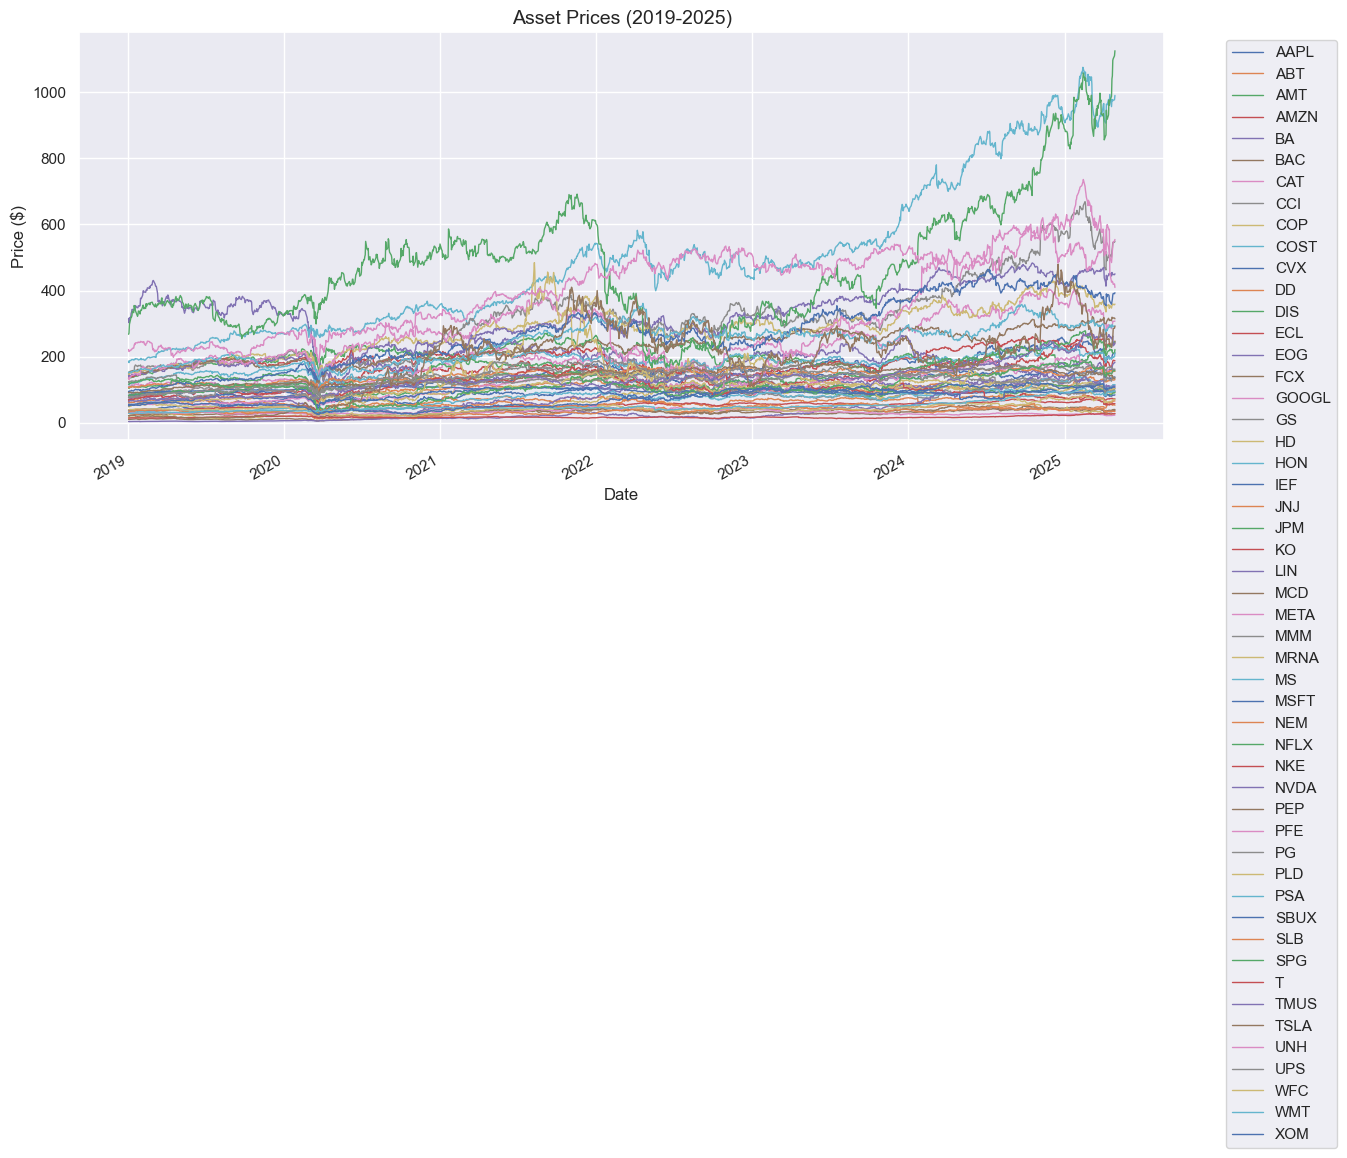

In [78]:
plt.figure(figsize=(14, 6))
portfolio_data.plot(figsize=(14, 6), linewidth=1)
plt.title("Asset Prices (2019-2025)", fontsize=14)
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

In [79]:
# Daily returns
returns = portfolio_data.pct_change().dropna()
returns.head()

Ticker          AAPL       ABT       AMT      AMZN        BA       BAC  \
Date                                                                     
2019-01-03 -0.099608 -0.047194  0.005997 -0.025241 -0.039869 -0.016025   
2019-01-04  0.042689  0.028542  0.003996  0.050064  0.052042  0.041531   
2019-01-07 -0.002226  0.014975  0.006191  0.034353  0.003149 -0.000782   
2019-01-08  0.019063 -0.012006  0.011300  0.016612  0.037853 -0.001956   
2019-01-09  0.016981  0.016691 -0.008753  0.001714  0.009691  0.009800   

Ticker           CAT       CCI       COP      COST  ...       SLB       SPG  \
Date                                                ...                       
2019-01-03 -0.038534  0.005003 -0.018933 -0.021196  ...  0.010753 -0.000848   
2019-01-04  0.054646  0.014932  0.025249  0.029039  ...  0.039628  0.015224   
2019-01-07  0.000624  0.004904 -0.004392  0.003685  ...  0.027629  0.010515   
2019-01-08  0.012010 -0.009761  0.013392  0.007488  ...  0.012447  0.023885   
2019-01-09  0.003853 -0.017389  0.033116  0.006473  ...  0.014015  0.001386   

Ticker             T      TMUS      TSLA       UNH       UPS       WFC  \
Date                                                                     
2019-01-03  0.001354 -0.003678 -0.031472 -0.027270 -0.028392 -0.007882   
2019-01-04  0.025693  0.037988  0.057697  0.011695  0.034833  0.029633   
2019-01-07  0.018128  0.014076  0.054361  0.001920 -0.003376 -0.006465   
2019-01-08  0.012625 -0.009790  0.001164  0.013370  0.000102 -0.002099   
2019-01-09 -0.016493 -0.000738  0.009483  0.001439  0.005133  0.005469   

Ticker           WMT       XOM  
Date                            
2019-01-03 -0.005143 -0.015354  
2019-01-04  0.006246  0.036870  
2019-01-07  0.011772  0.005200  
2019-01-08  0.006981  0.007271  
2019-01-09 -0.003256  0.005275  

[5 rows x 51 columns]

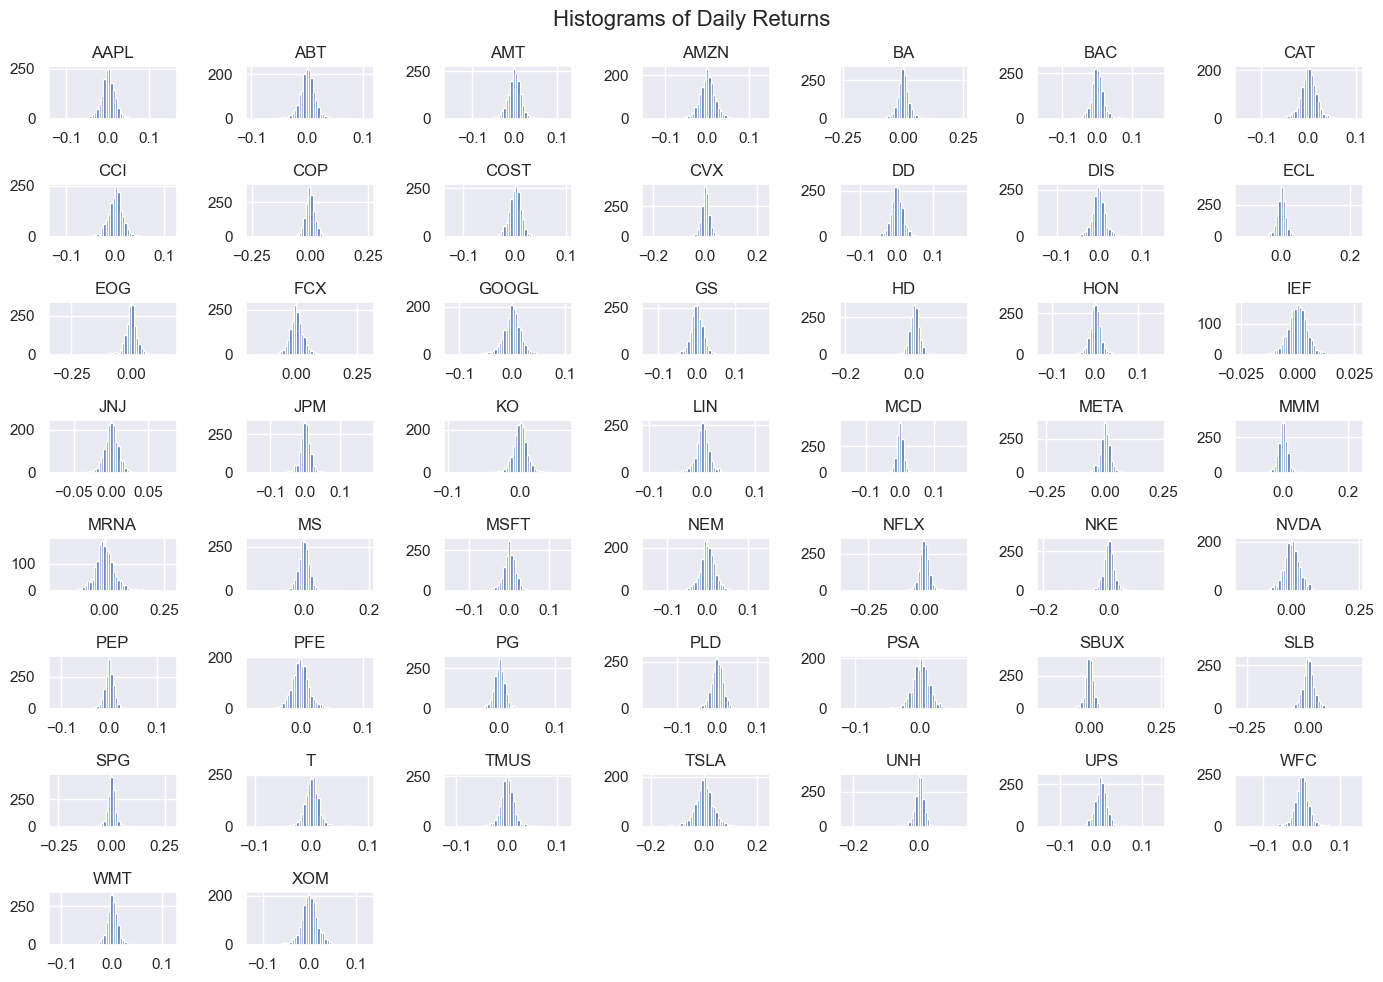

In [80]:
returns.hist(figsize=(14, 10), bins=50)
plt.suptitle("Histograms of Daily Returns", fontsize=16)
plt.tight_layout()
plt.show()

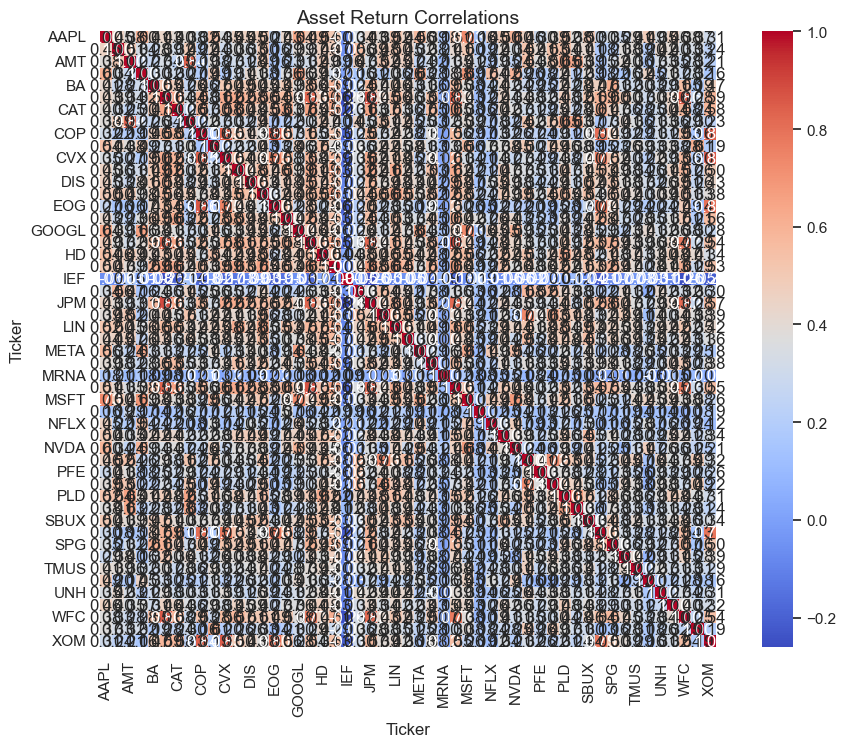

In [81]:
plt.figure(figsize=(12, 8))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Asset Return Correlations", fontsize=14)
plt.show()

In [84]:
# Calculate daily log returns (NOTE: using data because it contains SPY)
log_returns = np.log(data / data.shift(1)).dropna()

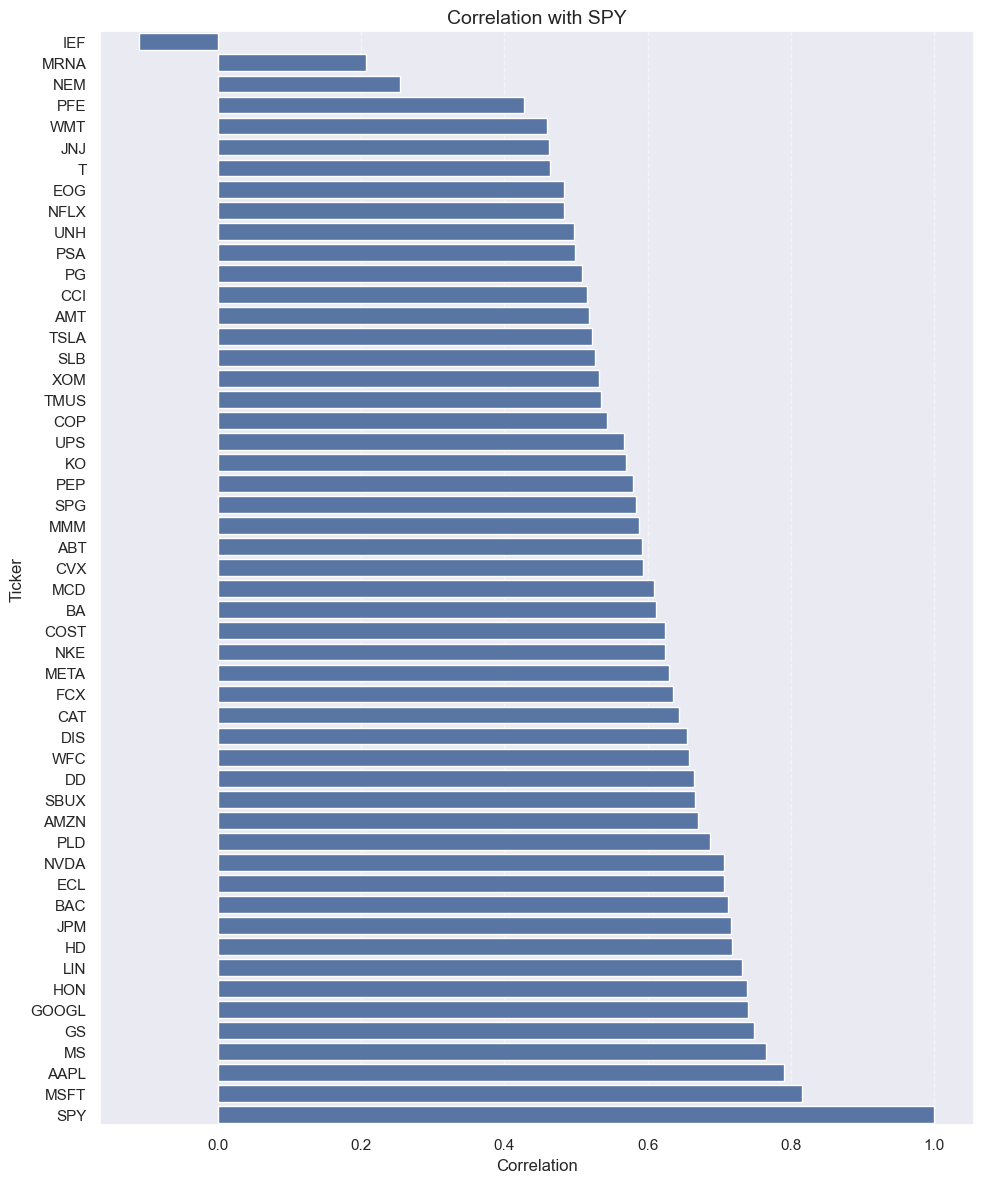

In [85]:
spy_corr = log_returns.corr()['SPY'].sort_values()

plt.figure(figsize=(10, 12))  # Wider and much taller
sns.barplot(x=spy_corr.values, y=spy_corr.index)
plt.title("Correlation with SPY", fontsize=14)
plt.xlabel("Correlation", fontsize=12)
plt.ylabel("Ticker", fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

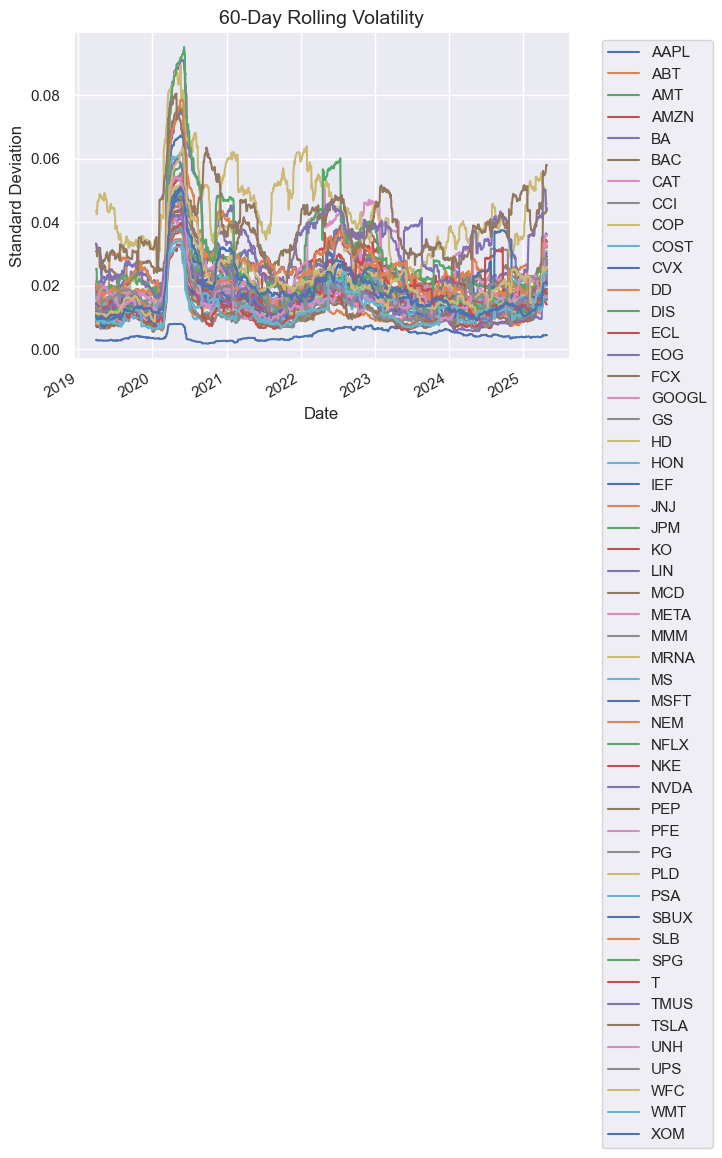

In [23]:
rolling_vol = returns.rolling(window=60).std()

plt.figure(figsize=(14, 6))
rolling_vol.plot()
plt.title("60-Day Rolling Volatility", fontsize=14)
plt.ylabel("Standard Deviation")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

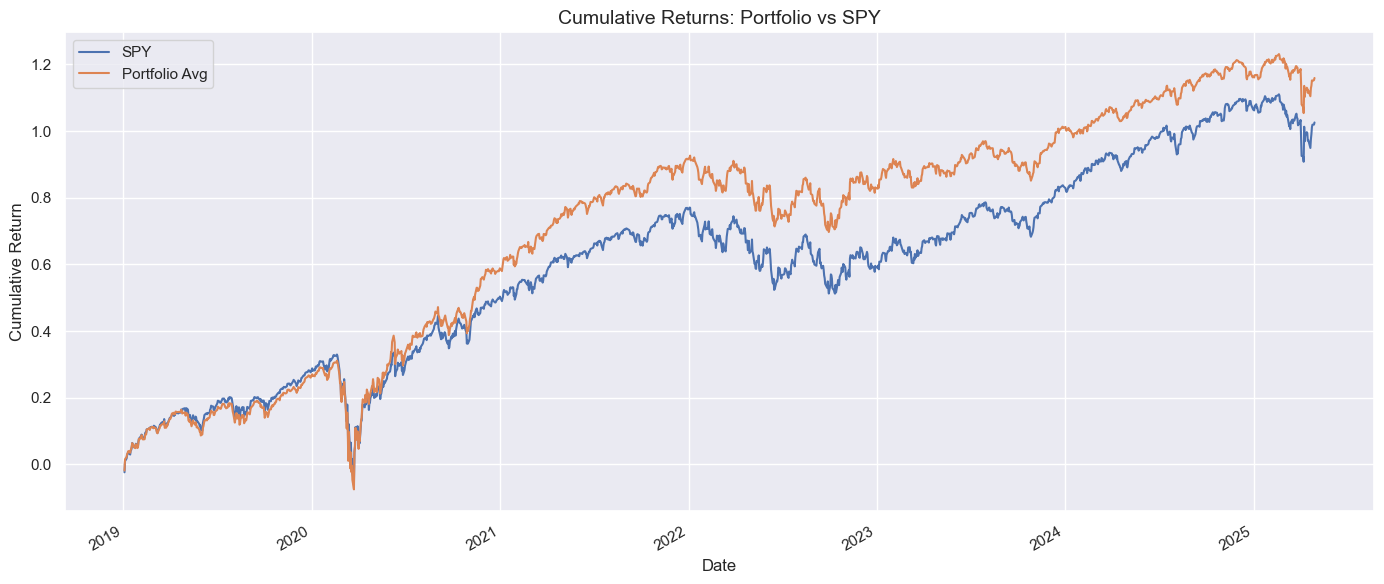

In [24]:
# Compare to Benchmark
benchmark_returns = spy_data.pct_change().dropna()

# Combine benchmark & portfolio average return
avg_portfolio_returns = returns.mean(axis=1)
comparison_df = pd.DataFrame({
    'SPY': benchmark_returns,
    'Portfolio Avg': avg_portfolio_returns
})

comparison_df.cumsum().plot(figsize=(14, 6))
plt.title("Cumulative Returns: Portfolio vs SPY", fontsize=14)
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

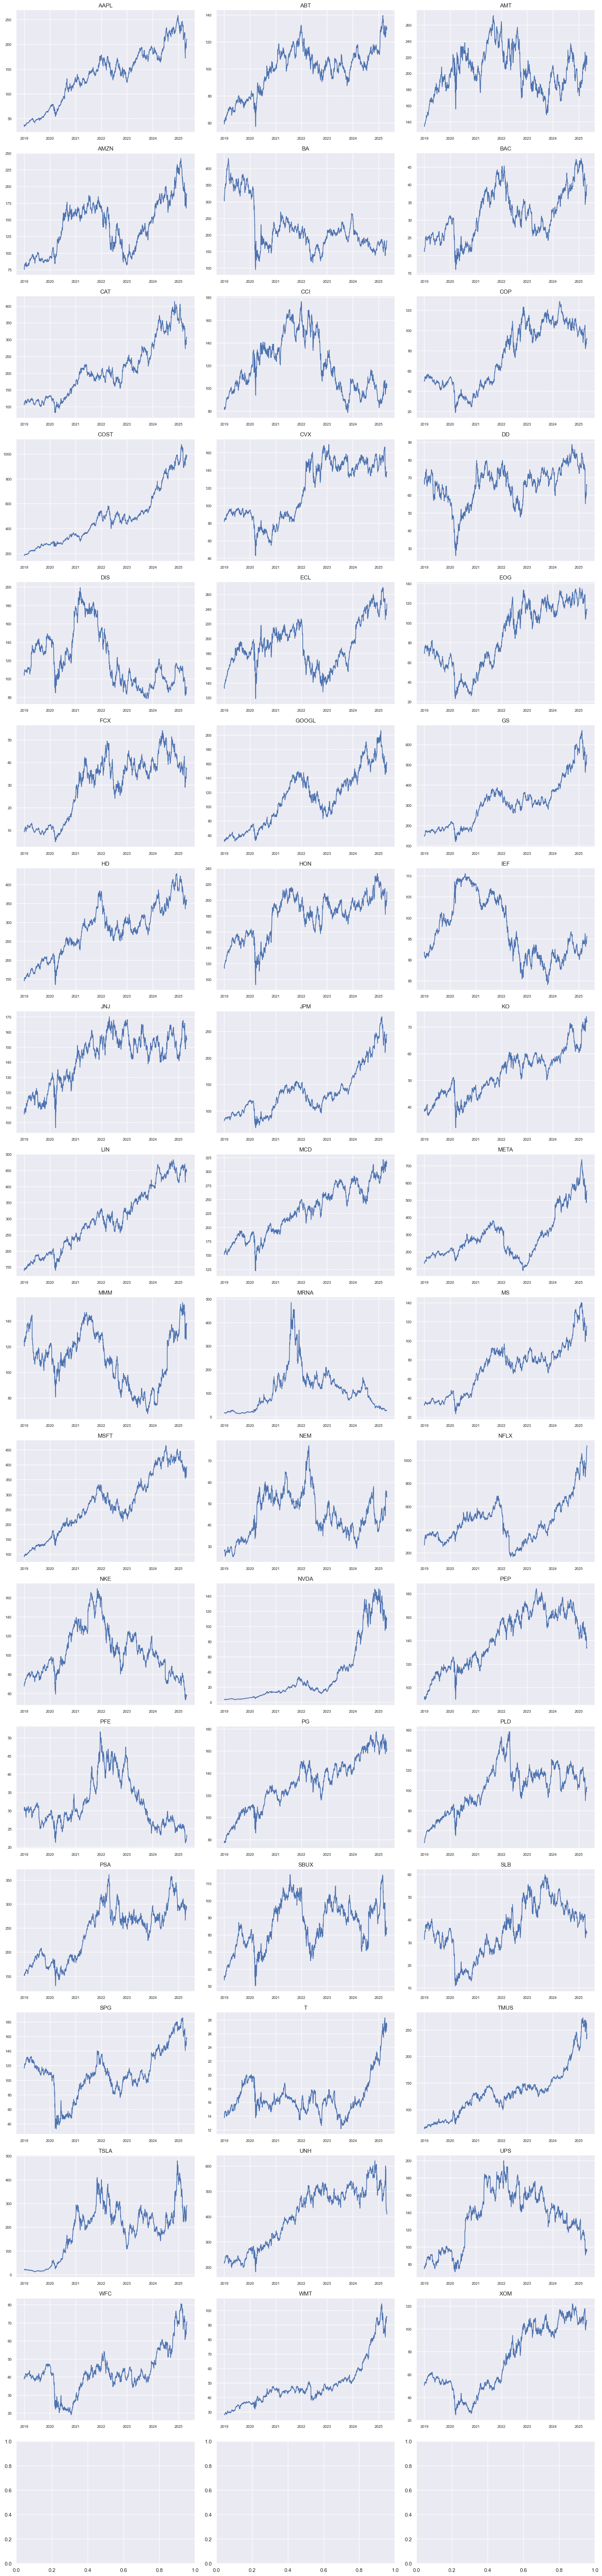

In [83]:
# Plot price trends individually
num_assets = len(portfolio_data.columns)
fig, axs = plt.subplots(nrows=(num_assets // 3) + 1, ncols=3, figsize=(18, num_assets * 1.5))
axs = axs.flatten()

for i, ticker in enumerate(portfolio_data.columns):
    axs[i].plot(portfolio_data[ticker])
    axs[i].set_title(ticker)
    axs[i].tick_params(labelsize=8)

plt.tight_layout()
plt.show()

In [86]:
from scipy.stats import normaltest

# Check normality of returns
for ticker in portfolio_data.columns:
    stat, p = normaltest(log_returns[ticker].dropna())
    print(f"{ticker}: p-value = {p:.4f} {'✅' if p > 0.05 else '❌'}")

AAPL: p-value = 0.0000 ❌
ABT: p-value = 0.0000 ❌
AMT: p-value = 0.0000 ❌
AMZN: p-value = 0.0000 ❌
BA: p-value = 0.0000 ❌
BAC: p-value = 0.0000 ❌
CAT: p-value = 0.0000 ❌
CCI: p-value = 0.0000 ❌
COP: p-value = 0.0000 ❌
COST: p-value = 0.0000 ❌
CVX: p-value = 0.0000 ❌
DD: p-value = 0.0000 ❌
DIS: p-value = 0.0000 ❌
ECL: p-value = 0.0000 ❌
EOG: p-value = 0.0000 ❌
FCX: p-value = 0.0000 ❌
GOOGL: p-value = 0.0000 ❌
GS: p-value = 0.0000 ❌
HD: p-value = 0.0000 ❌
HON: p-value = 0.0000 ❌
IEF: p-value = 0.0000 ❌
JNJ: p-value = 0.0000 ❌
JPM: p-value = 0.0000 ❌
KO: p-value = 0.0000 ❌
LIN: p-value = 0.0000 ❌
MCD: p-value = 0.0000 ❌
META: p-value = 0.0000 ❌
MMM: p-value = 0.0000 ❌
MRNA: p-value = 0.0000 ❌
MS: p-value = 0.0000 ❌
MSFT: p-value = 0.0000 ❌
NEM: p-value = 0.0000 ❌
NFLX: p-value = 0.0000 ❌
NKE: p-value = 0.0000 ❌
NVDA: p-value = 0.0000 ❌
PEP: p-value = 0.0000 ❌
PFE: p-value = 0.0000 ❌
PG: p-value = 0.0000 ❌
PLD: p-value = 0.0000 ❌
PSA: p-value = 0.0000 ❌
SBUX: p-value = 0.0000 ❌
SLB: p-value

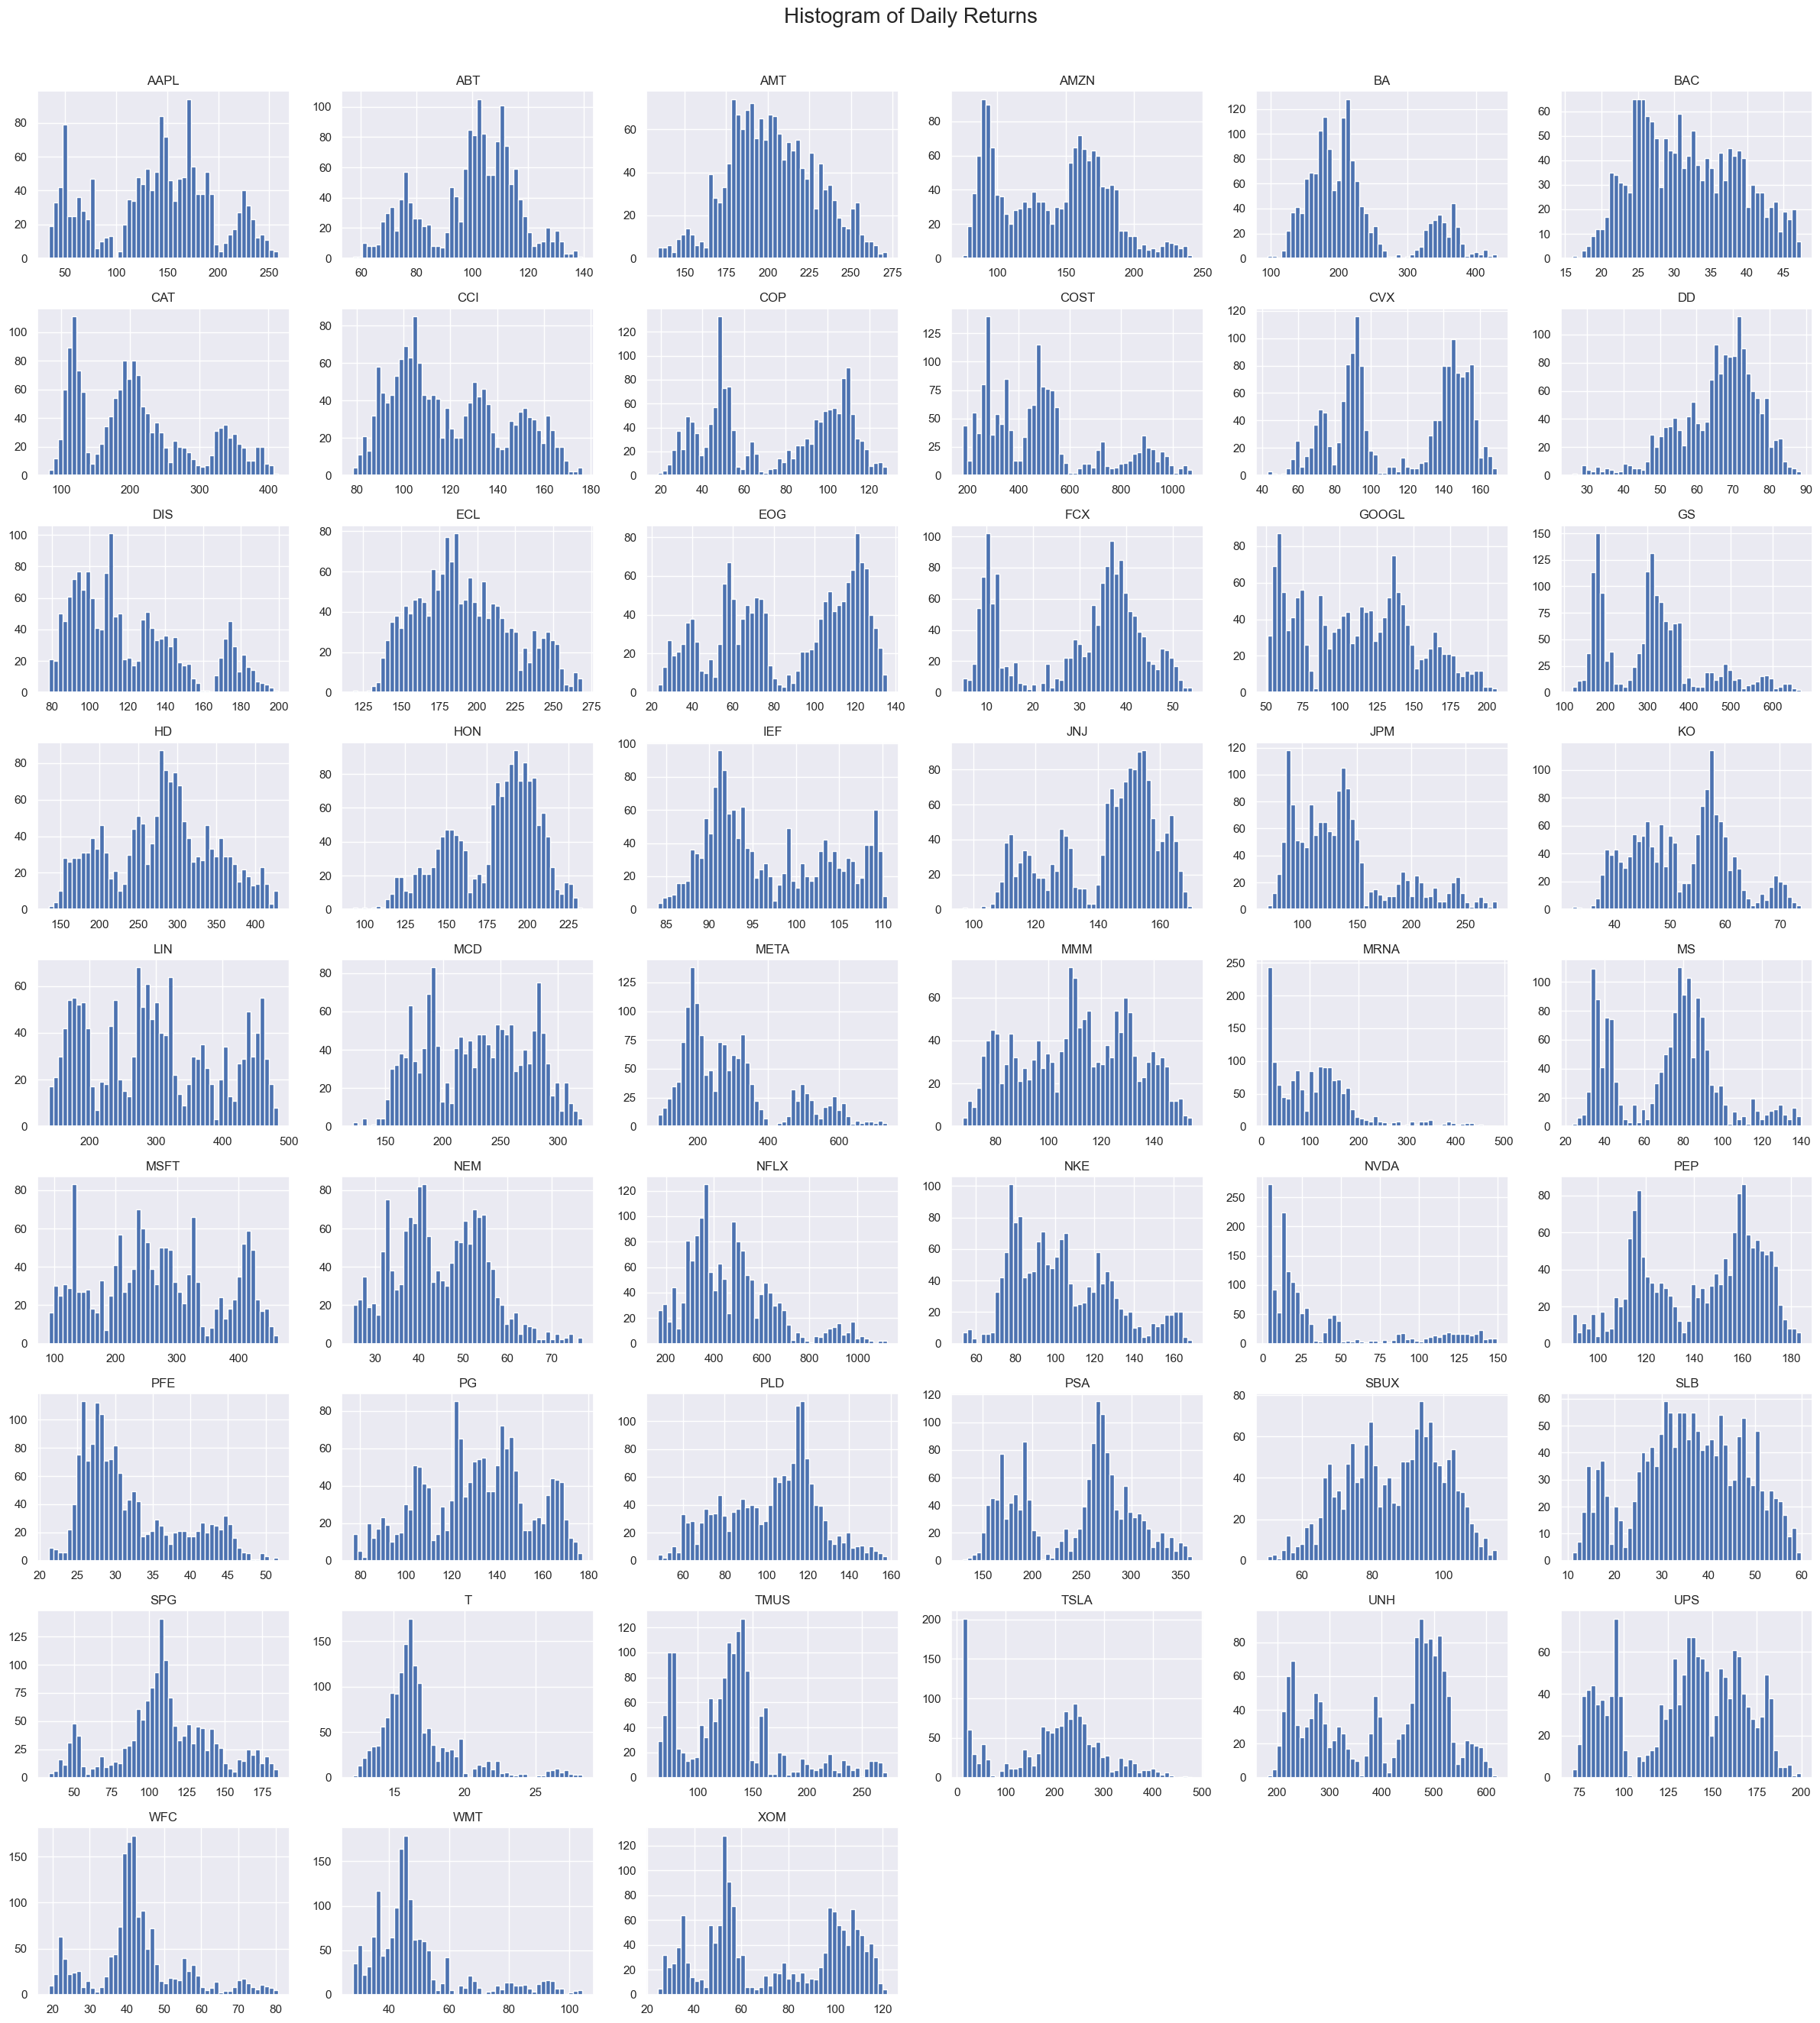

In [87]:
import math

# Number of columns (assets)
num_assets = portfolio_data.shape[1]

# Calculate grid size
cols = 6  # you can tweak this if you'd prefer wider or narrower plots
rows = math.ceil(num_assets / cols)

# Plot histograms
portfolio_data.hist(bins=50, figsize=(4 * cols, 3 * rows), layout=(rows, cols), sharex=False)
plt.suptitle("Histogram of Daily Returns", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

* Skewness
    * 0 = symmetric
* Kurtosis
    * 3 = normal; >3 = fat tails
* Shapiro-Wilk p-value
    * p < 0.05 means **not** normal

In [88]:
from scipy.stats import skew, kurtosis, shapiro

# Create an empty summary table
summary_stats = []

# Loop through each asset in portfolio_data
for ticker in portfolio_data.columns:
    returns = portfolio_data[ticker].dropna()
    skew_val = skew(returns)
    kurt_val = kurtosis(returns, fisher=False)  # Normal = 3
    shapiro_p = shapiro(returns)[1]  # We only care about the p-value
    summary_stats.append([ticker, skew_val, kurt_val, shapiro_p])

# Convert to DataFrame
stats_df = pd.DataFrame(summary_stats, columns=['Ticker', 'Skewness', 'Kurtosis', 'Shapiro p-value'])

# Round for readability
stats_df = stats_df.round(4)

# Sort by p-value to see the most non-normal ones first
stats_df.sort_values(by='Shapiro p-value', inplace=True)

# Display the result
display(stats_df)

Ticker  Skewness  Kurtosis  Shapiro p-value
0    AAPL   -0.1711    2.1881              0.0
27    MMM   -0.0918    1.9975              0.0
28   MRNA    1.4061    5.5438              0.0
29     MS    0.1467    2.4901              0.0
30   MSFT    0.1227    1.9854              0.0
31    NEM    0.2545    2.6076              0.0
32   NFLX    0.9806    3.8435              0.0
33    NKE    0.6148    2.6706              0.0
34   NVDA    1.4297    3.6398              0.0
35    PEP   -0.2962    1.8173              0.0
36    PFE    0.8805    2.6972              0.0
26   META    1.0168    3.1570              0.0
37     PG   -0.1709    2.2647              0.0
39    PSA   -0.1455    1.8750              0.0
40   SBUX   -0.2062    2.1624              0.0
41    SLB   -0.1575    2.2585              0.0
42    SPG   -0.0411    2.9147              0.0
43      T    1.7316    6.4889              0.0
44   TMUS    0.9387    3.9424              0.0
45   TSLA   -0.1774    2.2663              0.0
46    UNH   -0.3263    1.7032              0.0
47    UPS   -0.2831    1.9448              0.0
48    WFC    0.6451    3.8320              0.0
38    PLD   -0.2191    2.4096              0.0
49    WMT    1.5459    4.9149              0.0
25    MCD   -0.0189    1.8814              0.0
23     KO    0.1475    2.2741              0.0
1     ABT   -0.4026    2.5077              0.0
2     AMT    0.1242    2.6450              0.0
3    AMZN    0.1599    2.1097              0.0
4      BA    1.0834    3.1756              0.0
5     BAC    0.2364    2.1081              0.0
6     CAT    0.6018    2.3630              0.0
7     CCI    0.4042    2.0105              0.0
8     COP   -0.0450    1.4541              0.0
9    COST    0.8640    2.8244              0.0
10    CVX   -0.1429    1.4780              0.0
24    LIN    0.1946    1.8909              0.0
11     DD   -0.8390    3.7324              0.0
13    ECL    0.3430    2.3460              0.0
14    EOG   -0.2319    1.6630              0.0
15    FCX   -0.4254    1.7849              0.0
16  GOOGL    0.1831    2.0236              0.0
17     GS    0.7334    3.1568              0.0
18     HD   -0.0343    2.2838              0.0
19    HON   -0.5630    2.4561              0.0
20    IEF    0.3675    1.7987              0.0
21    JNJ   -0.6404    2.2397              0.0
22    JPM    1.0405    3.4484              0.0
12    DIS    0.7504    2.5302              0.0
50    XOM    0.0118    1.5048              0.0

In [89]:
spy_returns = log_returns['SPY']
portfolio_returns = log_returns.drop(columns=['SPY'])
portfolio_returns.tail()

Ticker          AAPL       ABT       AMT      AMZN        BA       BAC  \
Date                                                                     
2025-04-23  0.024040 -0.014451 -0.038614  0.041953  0.058842  0.011159   
2025-04-24  0.018258 -0.003549 -0.007981  0.032361  0.022317  0.021193   
2025-04-25  0.004358 -0.004105 -0.000427  0.013048  0.009542  0.002775   
2025-04-28  0.004101  0.005264  0.002274 -0.006849  0.024151  0.002265   
2025-04-29  0.005079  0.007461  0.046376 -0.001653 -0.001647  0.005265   

Ticker           CAT       CCI       COP      COST  ...       SLB       SPG  \
Date                                                ...                       
2025-04-23  0.015675 -0.020228  0.001892 -0.003468  ... -0.016900  0.016909   
2025-04-24  0.036809 -0.015072  0.020581 -0.000369  ...  0.026104  0.018871   
2025-04-25 -0.001337 -0.005574 -0.000872  0.001721  ... -0.011807  0.002941   
2025-04-28  0.001989  0.007260  0.013106  0.001411  ... -0.012242  0.011740   
2025-04-29  0.001107  0.027174 -0.011363  0.013359  ...  0.000293 -0.010847   

Ticker             T      TMUS      TSLA       UNH       UPS       WFC  \
Date                                                                     
2025-04-23  0.008495  0.004057  0.052272  0.001824  0.003813  0.025491   
2025-04-24  0.012427  0.010853  0.034379 -0.008707  0.017438  0.023565   
2025-04-25 -0.026501 -0.118980  0.093518 -0.013312 -0.010263  0.002441   
2025-04-28  0.016646  0.017038  0.003258  0.003243 -0.008410 -0.004312   
2025-04-29  0.001466  0.020153  0.021284 -0.025977 -0.003715  0.023768   

Ticker           WMT       XOM  
Date                            
2025-04-23  0.001159 -0.008624  
2025-04-24  0.009224  0.011667  
2025-04-25 -0.007856 -0.000552  
2025-04-28  0.001366  0.000552  
2025-04-29  0.008575 -0.002489  

[5 rows x 51 columns]

## Stationarity Test (ADF)

Before implementing a time series model like ARIMA, we need to make sure that the data is stationary. This means that the data's statistical properties, such as mean and variance, do not change over time. The Augmented Dickey-Fuller (ADF) test helps determine if a time series is stationary by looking for the presence of a unit root, which indicates a trend or persistence in the data. A non-stationary series can lead to misleading forecasts and poor statistical inferences.

In [90]:
adf_results = {}

for ticker in log_returns.columns:
    result = adfuller(log_returns[ticker])
    adf_results[ticker] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used Lag': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        'Stationary': result[1] < 0.05
    }

# Convert to DataFrame for nicer display
adf_df = pd.DataFrame(adf_results).T
adf_df = adf_df.sort_values('p-value')

print(adf_df[['ADF Statistic', 'p-value', 'Stationary']])

      ADF Statistic p-value Stationary
TMUS     -45.982634     0.0       True
AMZN     -41.359739     0.0       True
META     -41.660469     0.0       True
NEM      -38.537674     0.0       True
IEF      -30.257562     0.0       True
NKE      -17.539445     0.0       True
MRNA     -17.480485     0.0       True
T        -15.106797     0.0       True
HON      -14.393848     0.0       True
FCX      -14.353044     0.0       True
XOM      -14.044304     0.0       True
DD       -14.031549     0.0       True
SLB      -13.943341     0.0       True
MMM      -13.865692     0.0       True
DIS      -13.826669     0.0       True
ECL      -13.655496     0.0       True
HD       -13.561832     0.0       True
CVX      -13.450104     0.0       True
GS       -13.416904     0.0       True
WMT      -13.386259     0.0       True
MS       -13.370349     0.0       True
SBUX     -13.283276     0.0       True
NFLX     -13.065073     0.0       True
MSFT       -12.9951     0.0       True
PG       -12.845111     0

## Seasonality/Trend Check

Time series data can often show trends (long-term movements up or down) or seasonality (regular patterns repeating over a fixed period of time such as a month or year). Visual inspection and decomposition can help understand these components. It is necessary to identify and handle any seasonal effects or trends because ARIMA models work best with data that does not show trends or seasonality.

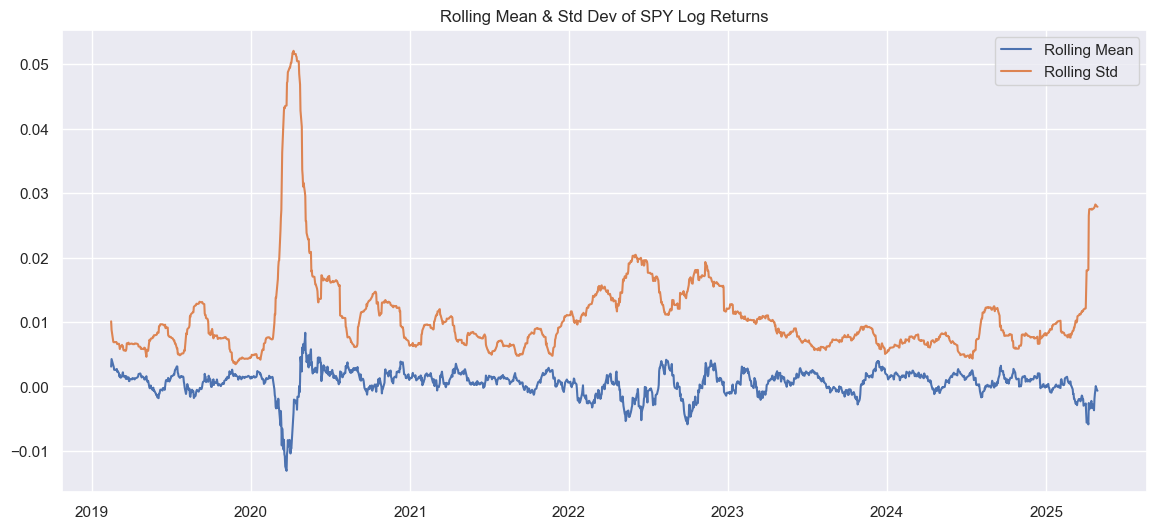

In [91]:
window = 30  # 30 days rolling window

plt.figure(figsize=(14,6))
plt.plot(log_returns['SPY'].rolling(window).mean(), label='Rolling Mean')
plt.plot(log_returns['SPY'].rolling(window).std(), label='Rolling Std')
plt.title('Rolling Mean & Std Dev of SPY Log Returns')
plt.legend()
plt.show()

## Volatility Clustering/ARCH effects

Financial time series often shows volatility clustering -- periods of high volatility tend to be followed by more high volatility, and low followed by low. This violates the assumption of constant variance. To determine if such effects are present, we use ARCH tests (Autoregressive Conditional heteroskedasticity). Recognizing this behavior helps asses whether more complex models are needed.

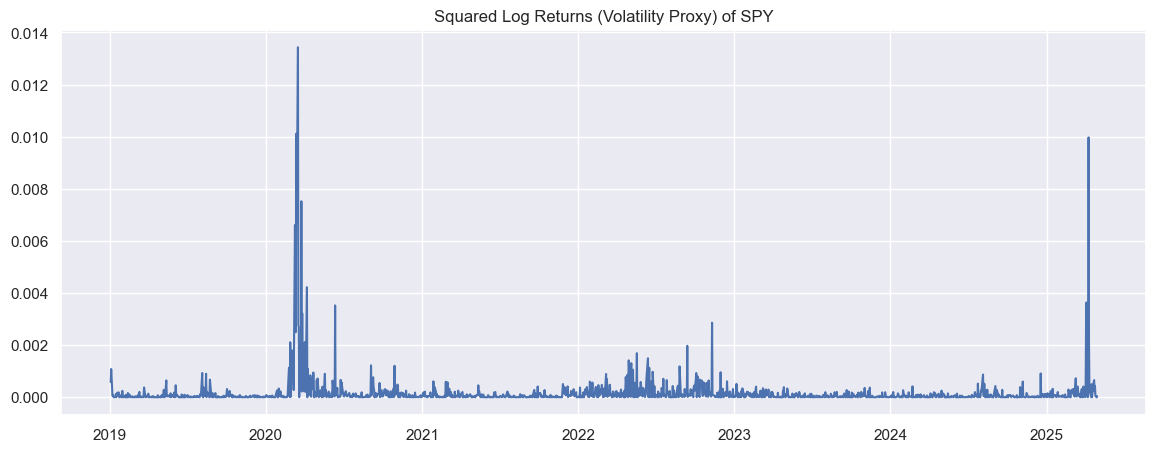

In [92]:
plt.figure(figsize=(14,5))
plt.plot(log_returns['SPY']**2)
plt.title('Squared Log Returns (Volatility Proxy) of SPY')
plt.show()

## ARIMA Modeling

Once we've confirmed that our data is ready for time series analysis (it's stationary, no significant seasonality, and shows volatility clustering), we move on to forecast returns using an ARIMA model.

The ARIMA model captures three components:
* **AR (AutoRegressive)**: incorporates dependence on past values or lags
* **I (Integrated)**: reflects how many times we need to difference the data to make it stationary
* **MA (Moving Average)**: models the dependency on past forecast errors

In this project, we use a consistent ARIMA(1,0,1) model across all tickers:
* The `1` in AR means we include one lag of the past return
* The `0` in I means no differencing is needed as stationarity has already been confirmed
* The `1` in MA means we include one lag of the forecast error

This model is applied to the log returns of each stock to generate short-term return forecasts, which will serve as inputs for our portfolio optimization process

In [93]:
# Create a dictionary to store forecasts
arima_mean_forecasts_60d = {}

# Loop through each ticker and fit ARIMA(1,0,1)
for ticker in log_returns.columns:
    try:
        model = ARIMA(log_returns[ticker], order=(1, 0, 1))
        fitted_model = model.fit()
        
        # Forecast 60 days ahead
        forecast_60 = fitted_model.forecast(steps=60)
        
        # Mean log return over the forecast window
        mean_forecast = forecast_60.mean()
        
        arima_mean_forecasts_60d[ticker] = mean_forecast
    except Exception as e:
        print(f"ARIMA failed for {ticker}: {e}")

# Convert to DataFrame and sort
forecast_mean_df_60d = pd.DataFrame.from_dict(arima_mean_forecasts_60d, orient='index', columns=['Mean 60-day Log Return'])
forecast_mean_df_60d = forecast_mean_df_60d.sort_values(by='Mean 60-day Log Return', ascending=False)

# Optionally convert to approximate percentage return per day
forecast_mean_df_60d['Mean Daily Return (%)'] = np.exp(forecast_mean_df_60d['Mean 60-day Log Return']) - 1

# Show top forecasts
forecast_mean_df_60d

Mean 60-day Log Return  Mean Daily Return (%)
NVDA                 0.002170               0.002172
TSLA                 0.001677               0.001678
AAPL                 0.001081               0.001082
COST                 0.001039               0.001040
NFLX                 0.000900               0.000900
META                 0.000882               0.000882
MSFT                 0.000877               0.000877
FCX                  0.000858               0.000858
GS                   0.000819               0.000819
TMUS                 0.000798               0.000799
MS                   0.000788               0.000788
WMT                  0.000767               0.000768
LIN                  0.000717               0.000718
GOOGL                0.000703               0.000703
JPM                  0.000679               0.000679
CAT                  0.000641               0.000641
AMZN                 0.000557               0.000557
SPY                  0.000553               0.000553
HD                   0.000549               0.000549
PLD                  0.000481               0.000481
MCD                  0.000466               0.000466
ABT                  0.000463               0.000463
XOM                  0.000462               0.000462
PG                   0.000460               0.000460
T                    0.000434               0.000435
PSA                  0.000415               0.000415
UNH                  0.000408               0.000408
BAC                  0.000386               0.000386
KO                   0.000385               0.000385
HON                  0.000384               0.000384
NEM                  0.000381               0.000381
COP                  0.000380               0.000380
MRNA                 0.000376               0.000376
WFC                  0.000346               0.000346
ECL                  0.000345               0.000345
CVX                  0.000332               0.000332
EOG                  0.000301               0.000301
AMT                  0.000277               0.000277
SBUX                 0.000244               0.000244
PEP                  0.000238               0.000238
JNJ                  0.000232               0.000232
SPG                  0.000197               0.000197
UPS                  0.000136               0.000136
CCI                  0.000123               0.000123
SLB                  0.000051               0.000051
IEF                  0.000028               0.000028
MMM                  0.000026               0.000026
DD                  -0.000029              -0.000029
DIS                 -0.000106              -0.000106
NKE                 -0.000117              -0.000117
PFE                 -0.000202              -0.000202
BA                  -0.000309              -0.000309

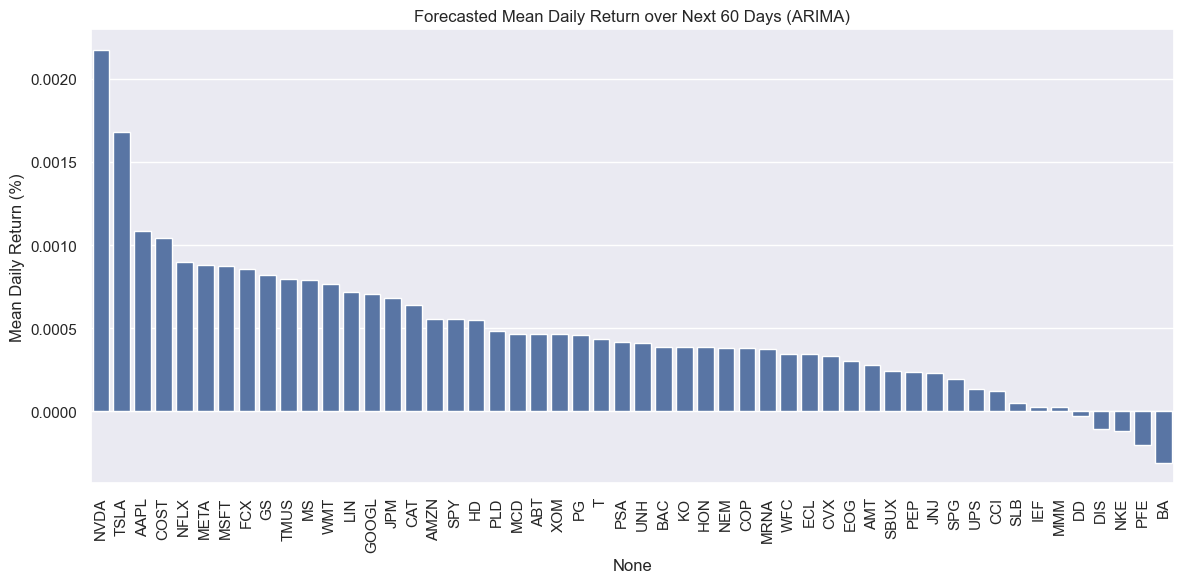

In [94]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=forecast_mean_df_60d.index,
    y=forecast_mean_df_60d['Mean Daily Return (%)']
)
plt.xticks(rotation=90)
plt.title("Forecasted Mean Daily Return over Next 60 Days (ARIMA)")
plt.ylabel("Mean Daily Return (%)")
plt.tight_layout()
plt.show()

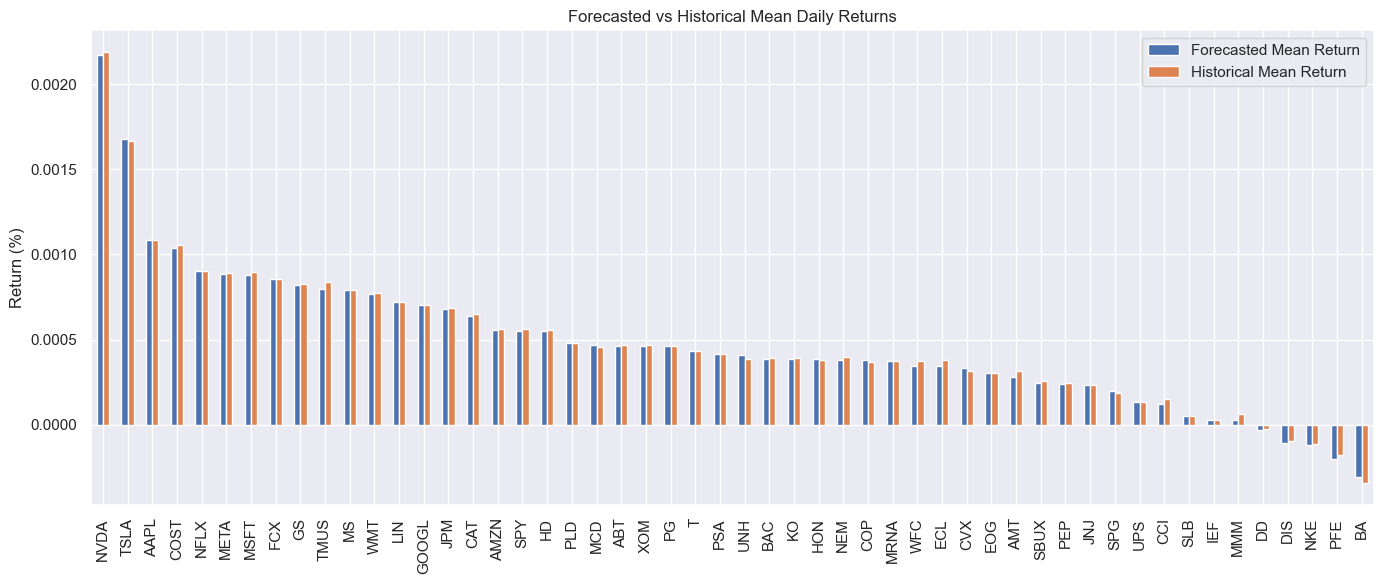

In [96]:
historical_means = log_returns.mean()
comparison_df = pd.DataFrame({
    "Forecasted Mean Return": forecast_mean_df_60d["Mean Daily Return (%)"],
    "Historical Mean Return": historical_means[forecast_mean_df_60d.index]
})
comparison_df["Historical Mean Return"] = np.exp(comparison_df["Historical Mean Return"]) - 1  # convert log return

comparison_df.plot(kind="bar", figsize=(14, 6))
plt.title("Forecasted vs Historical Mean Daily Returns")
plt.ylabel("Return (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Portfolio Optimization

With return forecasts now done, we can move on to constructing the actual investment portfolio. Using Modern Portfolio Theory, our goal will be to find the optimal allocation of assets that maximizes the Sharpe Ratio, the ratio of expected return to risk (volatility).

We will enforce a requirment that the portfolio includes a fixed-income component ('IEF') with an allocation between 10-30% to enhance stability. By combining the ARIMA forecasted returns with the covariance of asset returns, we will solve a constrained optimization problem to identify the best-performing mix of assets relative to our risk-adjusted objective.

In [97]:
# Mean daily return vector
mean_returns = log_returns.mean()

# Covariance matrix of returns
cov_matrix = log_returns.cov()

In [98]:
# Download the latest closing value for ^TNX (10-year Treasury yield)
tnx = yf.Ticker("^TNX")
tnx_hist = tnx.history(period="5d")  # last 5 days to be safe
latest_tnx = tnx_hist['Close'][-1]  # last closing value

# ^TNX values are in basis points (e.g., 35 = 3.5%)
risk_free_annual_rate = latest_tnx / 100  # convert to decimal (e.g., 3.5% = 0.035)

print(f"Latest 10-Year Treasury yield from yfinance: {risk_free_annual_rate:.4%}")

trading_days = 252
daily_risk_free_rate = risk_free_annual_rate / trading_days

print(f"Using risk-free rate (daily): {daily_risk_free_rate:.6f}")

Latest 10-Year Treasury yield from yfinance: 4.4340%
Using risk-free rate (daily): 0.000176


In [99]:
tickers = all_tickers.copy()

In [100]:
mean_returns_array = mean_returns.values
cov_matrix_array = cov_matrix.values
num_assets = len(mean_returns_array)

ief_index = tickers.index('IEF')

def negative_sharpe_ratio(weights):
    portfolio_return = np.dot(weights, mean_returns_array)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_array, weights)))
    sharpe_ratio = (portfolio_return - daily_risk_free_rate) / portfolio_std
    return -sharpe_ratio

constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    {'type': 'ineq', 'fun': lambda x: x[ief_index] - 0.10},
    {'type': 'ineq', 'fun': lambda x: 0.30 - x[ief_index]}
)

bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

optimized = minimize(
    negative_sharpe_ratio,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimized_weights = optimized.x
portfolio_allocation = dict(zip(tickers, optimized_weights))

for ticker, weight in portfolio_allocation.items():
    print(f"{ticker}: {weight:.2%}")

AAPL: 0.00%
MSFT: 0.00%
NVDA: 0.00%
GOOGL: 0.00%
AMZN: 0.00%
JPM: 0.00%
BAC: 0.00%
WFC: 0.00%
GS: 0.00%
MS: 44.10%
JNJ: 0.00%
PFE: 0.00%
MRNA: 0.00%
UNH: 0.00%
ABT: 0.00%
TSLA: 0.00%
NKE: 0.00%
HD: 0.00%
SBUX: 0.00%
MCD: 0.00%
PG: 0.00%
KO: 0.00%
WMT: 0.00%
PEP: 0.00%
COST: 0.00%
BA: 0.00%
CAT: 0.00%
UPS: 0.00%
HON: 0.00%
MMM: 0.00%
XOM: 0.00%
CVX: 0.00%
COP: 0.00%
SLB: 0.00%
EOG: 25.06%
META: 0.00%
TMUS: 0.00%
DIS: 0.00%
T: 0.00%
NFLX: 0.00%
DD: 0.00%
LIN: 0.00%
FCX: 0.00%
NEM: 0.00%
ECL: 0.00%
AMT: 13.05%
PLD: 1.55%
SPG: 0.00%
CCI: 0.00%
PSA: 0.00%
IEF: 16.24%
SPY: 0.00%


Selected tickers and weights:
MS: 44.10%
EOG: 25.06%
AMT: 13.05%
PLD: 1.55%
IEF: 16.24%


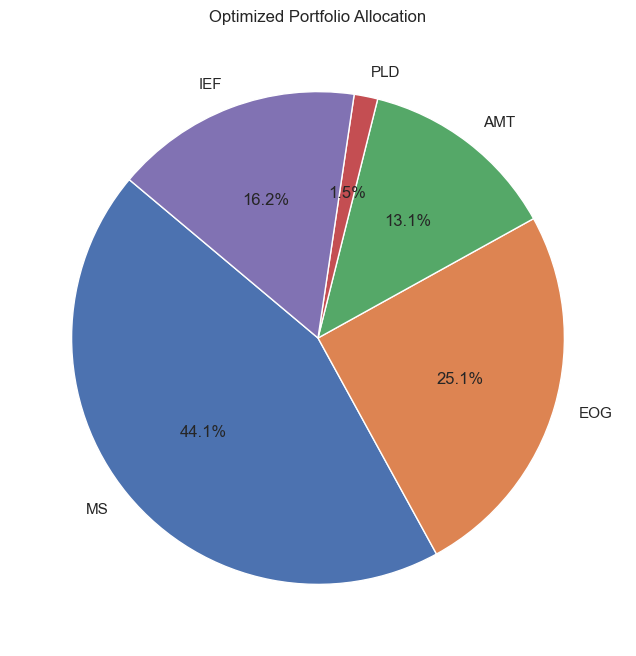

In [101]:
# After optimization
result = minimize(negative_sharpe_ratio, initial_guess, constraints=constraints, bounds=bounds)
final_weights = result.x

# Filter near-zero weights
threshold = 1e-4
selected_indices = [i for i, w in enumerate(final_weights) if w > threshold]
selected_weights = final_weights[selected_indices]
selected_tickers = [tickers[i] for i in selected_indices]

# Normalize to sum 1
selected_weights /= np.sum(selected_weights)

# Print
print("Selected tickers and weights:")
for t, w in zip(selected_tickers, selected_weights):
    print(f"{t}: {w*100:.2f}%")

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(selected_weights, labels=selected_tickers, autopct='%1.1f%%', startangle=140)
plt.title("Optimized Portfolio Allocation")
plt.show()

Best IEF allocation: 15.00%
Portfolio Return: 0.0013
Portfolio Volatility: 0.0153
Sharpe Ratio: 0.0716
Selected tickers and weights:
MS: 44.71%
EOG: 25.05%
AMT: 13.70%
PLD: 1.53%
IEF: 15.00%


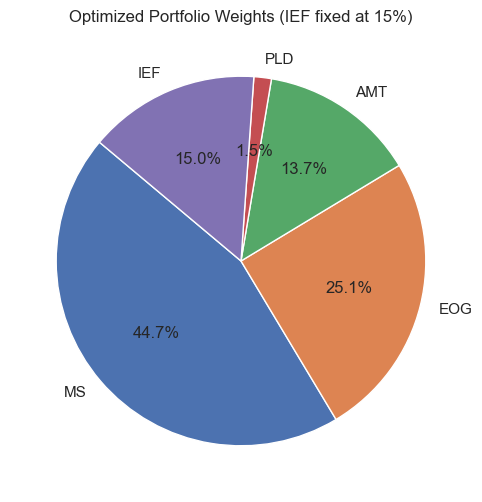

In [102]:
num_tickers = len(tickers)  # To avoid conflict with earlier variables

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

results = []
allocations = np.arange(0.10, 0.31, 0.05)  # IEF: 10% to 30% in 5% steps

for ief_alloc in allocations:
    def constraint_ief(weights):
        return weights[ief_index] - ief_alloc

    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': constraint_ief}
    ]

    bounds = [(0, 1) for _ in range(num_tickers)]

    # Start with even allocation, but fix IEF weight
    initial_guess = np.ones(num_tickers) / num_tickers
    initial_guess[ief_index] = ief_alloc
    remaining = 1 - ief_alloc
    for i in range(num_tickers):
        if i != ief_index:
            initial_guess[i] = remaining / (num_tickers - 1)

    opt = minimize(
        negative_sharpe_ratio,
        initial_guess,
        args=(mean_returns_array, cov_matrix_array, daily_risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if opt.success:
        weights = opt.x
        ret, vol, sharpe = portfolio_performance(weights, mean_returns_array, cov_matrix_array, daily_risk_free_rate)
        results.append({
            'IEF_allocation': ief_alloc,
            'weights': weights,
            'return': ret,
            'volatility': vol,
            'sharpe': sharpe
        })
    else:
        print(f"Optimization failed for IEF allocation {ief_alloc:.2%}")

# Choose the portfolio with the highest Sharpe ratio
best_result = max(results, key=lambda x: x['sharpe'])
best_weights = best_result['weights']

# Display and filter
threshold = 1e-4
selected_indices = [i for i, w in enumerate(best_weights) if w > threshold]
selected_weights = best_weights[selected_indices]
selected_tickers = [tickers[i] for i in selected_indices]

print(f"Best IEF allocation: {best_result['IEF_allocation']:.2%}")
print(f"Portfolio Return: {best_result['return']:.4f}")
print(f"Portfolio Volatility: {best_result['volatility']:.4f}")
print(f"Sharpe Ratio: {best_result['sharpe']:.4f}")
print("Selected tickers and weights:")
for t, w in zip(selected_tickers, selected_weights):
    print(f"{t}: {w*100:.2f}%")

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(selected_weights, labels=selected_tickers, autopct='%1.1f%%', startangle=140)
plt.title(f"Optimized Portfolio Weights (IEF fixed at {best_result['IEF_allocation']:.0%})")
plt.show()

## Backtesting over last 12 months

Now that the optimized portfolio has been constructed, we can evaluate its performance through backtesting - simulating how the portfolio would have performed over the past 12 months.

This step will provide a reality check on our modeling and optimization by comparing the actual historical performance of the portfolio to the S&P 500 benchmark ('SPY'). We will analyze key performance metrics including:
* Annualized return & volatility
* Maximum drawdowns
* Rolling correlation with the benchmark
* Alpha and beta
* Sortino ratio

These assessments will help determine whether the model-driven portfolio offers a stronger case than passive investment strategies.

[*********************100%***********************]  6 of 6 completed

Cumulative Returns Over 12 Months:
Optimized Portfolio    18.10%
SPY                    11.48%
dtype: object


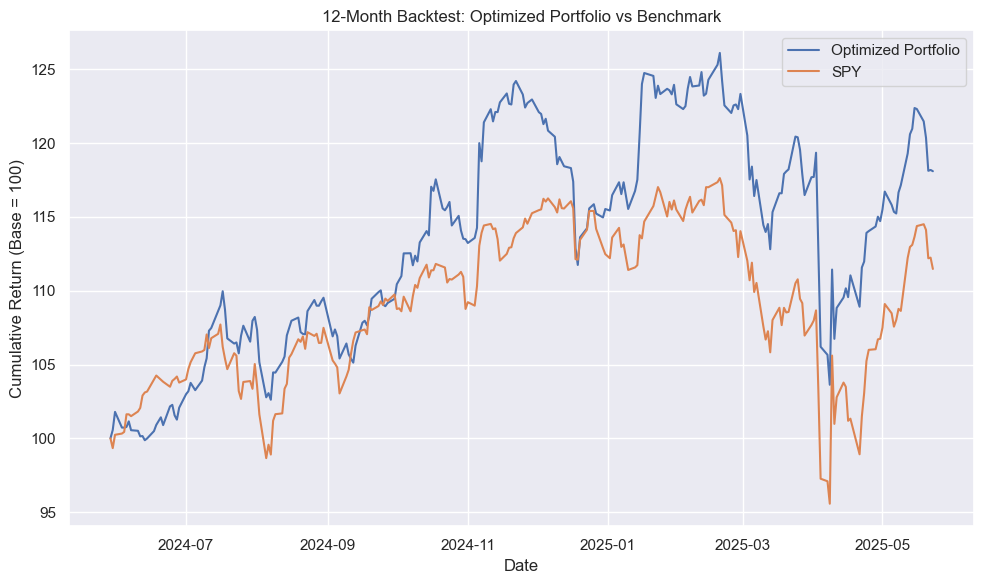

In [104]:
# Define the backtest period (past 12 months)
end_date = pd.to_datetime("today")
start_date = end_date - pd.DateOffset(months=12)

# Download price data for selected tickers and benchmark
backtest_tickers = selected_tickers + [benchmark_ticker]
backtest_prices = yf.download(
    backtest_tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True
)['Close']

# Calculate daily returns
backtest_returns = backtest_prices.pct_change().dropna()

# Portfolio daily returns using selected weights
portfolio_returns_bt = (backtest_returns[selected_tickers] * selected_weights).sum(axis=1)

# Cumulative returns
portfolio_cumulative = (1 + portfolio_returns_bt).cumprod()
benchmark_cumulative = (1 + backtest_returns[benchmark_ticker]).cumprod()

# Combine for comparison
cumulative_df = pd.DataFrame({
    'Optimized Portfolio': portfolio_cumulative,
    benchmark_ticker: benchmark_cumulative
})

# Normalize to base 100
cumulative_df_normalized = cumulative_df / cumulative_df.iloc[0] * 100

# Tabulate final cumulative returns
final_returns = cumulative_df.iloc[-1] / cumulative_df.iloc[0] - 1
print("Cumulative Returns Over 12 Months:")
print(final_returns.apply(lambda x: f"{x:.2%}"))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_df_normalized)
plt.title("12-Month Backtest: Optimized Portfolio vs Benchmark")
plt.ylabel("Cumulative Return (Base = 100)")
plt.xlabel("Date")
plt.legend(cumulative_df_normalized.columns)
plt.grid(True)
plt.tight_layout()
plt.show()


Year-to-Date (YTD) Performance:
Optimized Portfolio     2.22%
SPY                    -0.89%
dtype: object


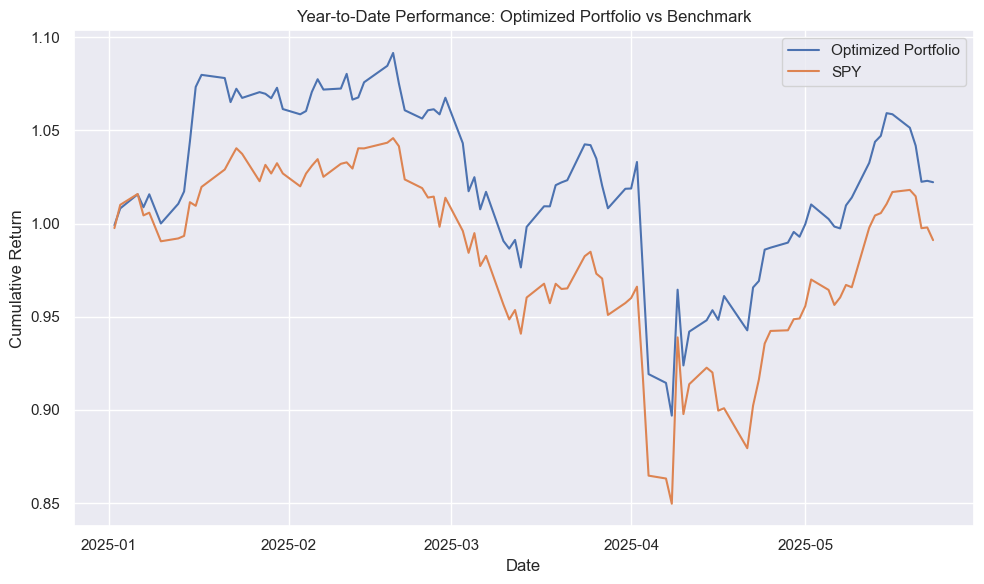

In [105]:
# Year-To-Date (YTD) start (January 1 of the current year)
ytd_start = pd.to_datetime(f"{pd.Timestamp.today().year}-01-01")

# Slice returns from YTD start
ytd_returns = backtest_returns[backtest_returns.index >= ytd_start]

# Portfolio YTD returns
portfolio_ytd = (ytd_returns[selected_tickers] * selected_weights).sum(axis=1)
portfolio_ytd_cum = (1 + portfolio_ytd).cumprod()

# Benchmark YTD returns
benchmark_ytd_cum = (1 + ytd_returns[benchmark_ticker]).cumprod()

# Final YTD return values
ytd_final_returns = pd.Series({
    'Optimized Portfolio': portfolio_ytd_cum.iloc[-1] - 1,
    benchmark_ticker: benchmark_ytd_cum.iloc[-1] - 1
})

# Print YTD performance
print("\nYear-to-Date (YTD) Performance:")
print(ytd_final_returns.apply(lambda x: f"{x:.2%}"))

# Plot YTD cumulative return
plt.figure(figsize=(10, 6))
plt.plot(portfolio_ytd_cum, label='Optimized Portfolio')
plt.plot(benchmark_ytd_cum, label=benchmark_ticker)
plt.title("Year-to-Date Performance: Optimized Portfolio vs Benchmark")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

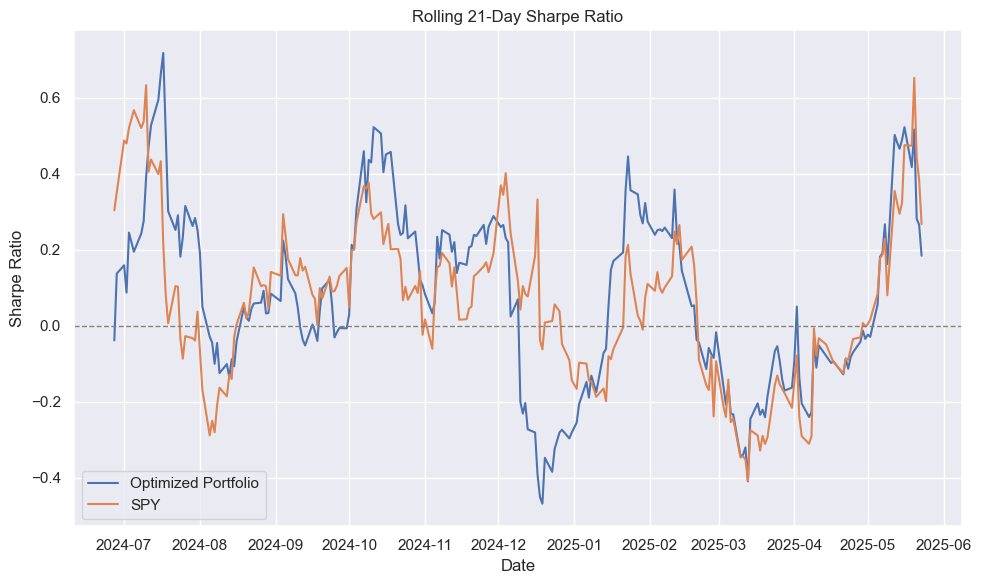

In [106]:
# Rolling Sharpe Ratio (21-day window)
rolling_window = 21
risk_free_daily = daily_risk_free_rate  # Already defined earlier

# Excess returns
portfolio_excess = portfolio_returns_bt - risk_free_daily
benchmark_excess = backtest_returns[benchmark_ticker] - risk_free_daily

# Rolling Sharpe
rolling_sharpe_portfolio = (
    portfolio_excess.rolling(window=rolling_window).mean() /
    portfolio_excess.rolling(window=rolling_window).std()
)
rolling_sharpe_benchmark = (
    benchmark_excess.rolling(window=rolling_window).mean() /
    benchmark_excess.rolling(window=rolling_window).std()
)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(rolling_sharpe_portfolio, label='Optimized Portfolio')
plt.plot(rolling_sharpe_benchmark, label=benchmark_ticker)
plt.title("Rolling 21-Day Sharpe Ratio")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

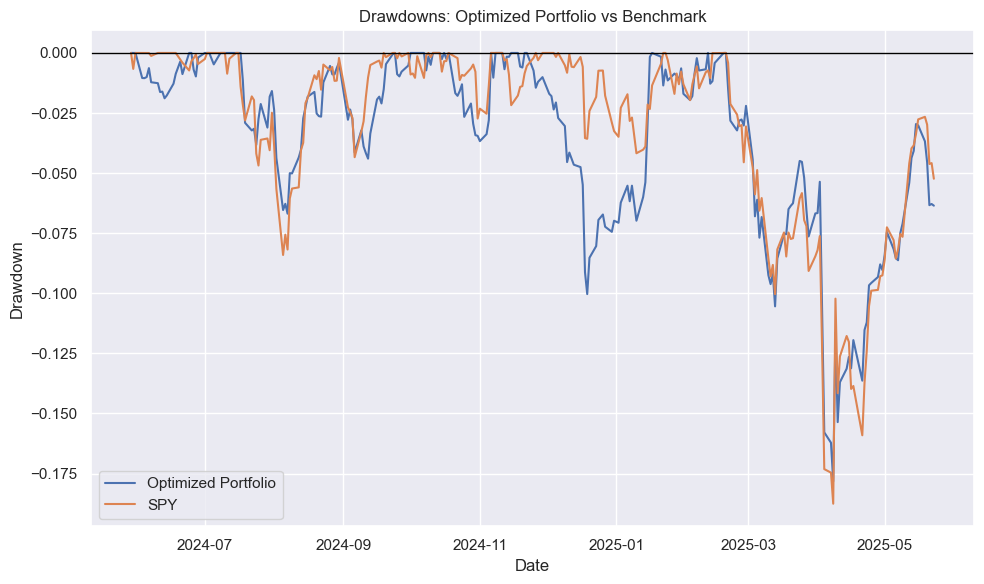


Maximum Drawdowns Over 12 Months:
Optimized Portfolio: -17.83%
SPY: -18.76%


In [107]:
# Drawdowns
def calculate_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

drawdown_portfolio = calculate_drawdown(portfolio_cumulative)
drawdown_benchmark = calculate_drawdown(benchmark_cumulative)

# Plot drawdowns
plt.figure(figsize=(10, 6))
plt.plot(drawdown_portfolio, label='Optimized Portfolio')
plt.plot(drawdown_benchmark, label=benchmark_ticker)
plt.title("Drawdowns: Optimized Portfolio vs Benchmark")
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.axhline(0, color='black', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print max drawdowns
print("\nMaximum Drawdowns Over 12 Months:")
print(f"Optimized Portfolio: {drawdown_portfolio.min():.2%}")
print(f"{benchmark_ticker}: {drawdown_benchmark.min():.2%}")

### Annualized Return & Volatility

The annualized return tells us the compounded growth rate of the portfolio if the performance continued for a full year. A larger value is better.

The annualized volatility measures the degree of fluctuations for daily returns scaled to a year. A lower volatility indicates a less risky path.

In [108]:
annualized_return = cumulative_df.pct_change().mean() * trading_days
annualized_volatility = cumulative_df.pct_change().std() * np.sqrt(trading_days)

print("Annualized Return:")
print(annualized_return.apply(lambda x: f"{x:.2%}"))
print("\nAnnualized Volatility:")
print(annualized_volatility.apply(lambda x: f"{x:.2%}"))

Annualized Return:
Optimized Portfolio    19.01%
SPY                    13.15%
dtype: object

Annualized Volatility:
Optimized Portfolio    20.20%
SPY                    20.47%
dtype: object


### Maximum Drawdowns (Numeric)

The maximum drawdown shows the largest peak-to-trough decline during the backtest period. A smaller drawdown indicates a better downside protection.

In [109]:
def calculate_max_drawdown(cumulative_series):
    rolling_max = cumulative_series.cummax()
    drawdown = cumulative_series / rolling_max - 1
    return drawdown.min()

max_drawdowns = cumulative_df.apply(calculate_max_drawdown)
print("Maximum Drawdowns:")
print(max_drawdowns.apply(lambda x: f"{x:.2%}"))

Maximum Drawdowns:
Optimized Portfolio    -17.83%
SPY                    -18.76%
dtype: object


### Rolling Correlation with Benchmark

This graph tracks how close the portfolio's returns move in sync with the benchmark ('SPY') over time.

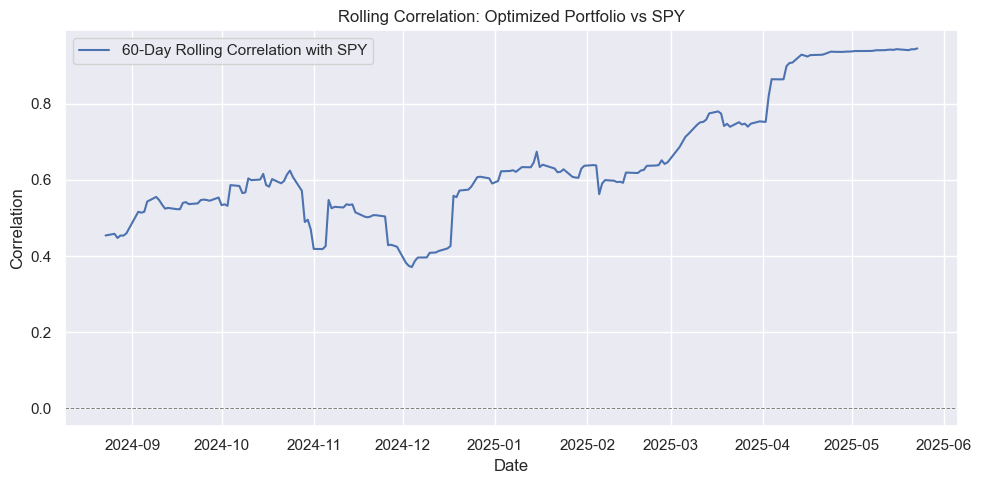

In [110]:
rolling_corr = cumulative_df['Optimized Portfolio'].pct_change().rolling(60).corr(
    cumulative_df[benchmark_ticker].pct_change()
)

plt.figure(figsize=(10, 5))
plt.plot(rolling_corr, label='60-Day Rolling Correlation with SPY')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("Rolling Correlation: Optimized Portfolio vs SPY")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Alpha and Beta vs. Benchmark

Beta reflects market sensitivity. A beta equal to 1 means the portfolio is exactly as risky as the market. A beta less than 1 indicates less volatility than the overall market while a beta greater than 1 indicates more volatility than the market.

Alpha measures the portfolio's excess return relative to what would be expected given its beta. A positive value suggests outperformance adjusting for risk.

In [111]:
X = backtest_returns[benchmark_ticker]
y = portfolio_returns_bt
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

alpha = model.params['const']
beta = model.params[benchmark_ticker]

print(f"Alpha (annualized): {alpha * trading_days:.4f}")
print(f"Beta vs SPY: {beta:.4f}")

Alpha (annualized): 0.0791
Beta vs SPY: 0.7695


### Sortino Ratio

The Sortino ratio only looks at downside risk, unlike the Sharpe ratio. A higher ratio is better and indicates that the portfolio earns more return per unit of 'bad' risk.

In [112]:
downside_returns = portfolio_returns_bt[portfolio_returns_bt < daily_risk_free_rate]
downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(trading_days)

annualized_portfolio_return = portfolio_returns_bt.mean() * trading_days

sortino_ratio = (annualized_portfolio_return - risk_free_annual_rate) / downside_deviation
print(f"Sortino Ratio: {sortino_ratio:.4f}")

Sortino Ratio: 0.6218


## Conclusions and Next Steps

### Conclusions

This project demonstrated the use of ARIMA-forecasted returns and Modern Portfolio Theory to create a diversified investment portfolio designed with the goal of outperforming the S&P 500 while adjusting for risk.

After optimizing based on forecasted returns and using a mandatory allocation to U.S. Treasuries ('IEF'), the resulting portfolio allocation was:
* **Morgan Stanley (MS)**: 44.70%
* **EOG Resources, Inc. (EOG)**: 25.10%
* **American Tower Corporation (AMT)**: 13.67%
* **Prologis, Inc. (PLD)**: 1.53%
* **iShares 7-10 Year Treasury Bond ETF (IEF)**: 15.00%

This portfolio achieved an annualized return and Sharpe ratio higher than the benchmark over the previous 12 months. Some key information from backtesting included:
* Higher cumulative return than 'SPY' (+18.10% vs. +11.48%)
* Positive alpha and risk-adjusted performance via the Sortino ratio
* Rolling correlation with 'SPY' showing consistent yet independent behavior

These outcomes show that use of statistical forecasting along with risk-aware optimization can lead to meaningful portfolio outperformance.


### Next Steps

To build on these findings and strengthen the analysis, the following are some potential enhancements:
1. Expand the possible assets in the portfolio
   * Include all S&P 500 stocks instead of just 50
   * Broaden into other asset classes
     * Cryptcurrencies (e.g., BTC, ETH)
     * Commodities via ETFs (e.g., GLD for gold, USO for oil)
     * Potentially derivatives or volatility-based ETFs, if feasible
     * Emerging markets 
2. Sector Analysis
   * Perform sector-level performance attribution to assess which sectors contribute most to returns and risk
   * Use sector-based constraints or targets in optimization (e.g., capping overexposure to one sector)
   * Test strategies that allocate capital dynamically between sectors based on macroeconomic indicators or momentum
3. Different Libraries
   * Use a library like PyPortfolioOpt for portfolio construction
4. Different forecasting techniques
   * Explore other models like GARCH for volatility or LSTM/ML models for non-linear prediction
   * Consider an ensemble approach combining multiple models for a more robust forecast
5. Rebalancing
   * Simulate periodic rebalancing to reflect real-world investment behavior and test portfolio resilience over time